# Credit Card Risk Classification

---

## Modules and Setup

In [48]:
import os as os
from IPython.display import Markdown, display
import numpy as np
import pandas.api.types as ptypes
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt 

In [49]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)

---

# 1. Project Overview

This project involves developing a machine learning model to classify individuals as low or high credit risks based on their attributes. Using a publicly available dataset, the goal is to accurately predict credit risk while exploring the underlying data and applying advanced modeling techniques.

---

# 2. Objectives

1. Perform exploratory data analysis (EDA) to understand the dataset and identify patterns
2. Preprocess and clean the data to prepare it for modeling
3. Build, evaluate, and compare multiple classification models
4. Interpret model results and provide further understanding of credit risk

---

# 3. Dataset

The [German Credit Risk](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) includes attributes related to individuals' financial history and demographics, with a target variable indicating whether they are a low or high credit risk.

---

# 4. Workflow

## 4.1. Loading and Tidying the Data

In [50]:
credit_risk = fetch_ucirepo(id=144) 
X_coded = credit_risk.data.features 
y_coded = credit_risk.data.targets

In [51]:
X_coded.head() # Display the features of the dataset

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


In [52]:
y_coded.head() # Labels

,class
0,1
1,2
2,1
3,1
4,2


In [53]:
rows, cols = X_coded.shape
text = f"The DataFrame contains **{rows} rows** and **{cols} columns**."
display(Markdown(text))

The DataFrame contains **1000 rows** and **20 columns**.

In [54]:
X_coded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute1   1000 non-null   object
 1   Attribute2   1000 non-null   int64 
 2   Attribute3   1000 non-null   object
 3   Attribute4   1000 non-null   object
 4   Attribute5   1000 non-null   int64 
 5   Attribute6   1000 non-null   object
 6   Attribute7   1000 non-null   object
 7   Attribute8   1000 non-null   int64 
 8   Attribute9   1000 non-null   object
 9   Attribute10  1000 non-null   object
 10  Attribute11  1000 non-null   int64 
 11  Attribute12  1000 non-null   object
 12  Attribute13  1000 non-null   int64 
 13  Attribute14  1000 non-null   object
 14  Attribute15  1000 non-null   object
 15  Attribute16  1000 non-null   int64 
 16  Attribute17  1000 non-null   object
 17  Attribute18  1000 non-null   int64 
 18  Attribute19  1000 non-null   object
 19  Attribute20  1000 non-null  

The DataFrame has no missing values, but all of the variables are encoded. All categorical variables will be decoded.

### 4.1.1 Decoding the Variables

The values will be decoded based on their definitions in the *german* Word document. Since each attribute is unique to its respective column, all mappings will be combined into a single comprehensive dictionary. The qualitative labels will be shortened for clarity and conciseness.

In [55]:
attribute1_mapping = {
    "A11": "<0 DM",               # Less than 0 DM
    "A12": "0<= ...<200 DM",      # Between 0 and 200 DM
    "A13": ">=200 DM",            # Greater than or equal to 200 DM or salary commitments
    "A14": "No checking account"  # No checking account
}

attribute3_mapping = {
    "A30": "No credits/perfect",    # No credits or perfect repayment
    "A31": "Perfect at bank",       # Perfect repayment at this bank
    "A32": "Good repayment",        # Good current repayment
    "A33": "Delays",                # History of delays
    "A34": "Critical/other credits" # High-risk or external credits
}

attribute4_mapping = {
    "A40": "New car",
    "A41": "Used car",
    "A42": "Furniture/equipment",
    "A43": "Radio/TV",
    "A44": "Appliances",
    "A45": "Repairs",
    "A46": "Education",
    "A47": "Vacation (not used)",
    "A48": "Retraining",
    "A49": "Business",
    "A410": "Others"
}

attribute6_mapping = {
    "A61": "<100 DM",        # Less than 100 DM
    "A62": "100-499 DM",     # Between 100 and 499 DM
    "A63": "500-999 DM",     # Between 500 and 999 DM
    "A64": ">=1000 DM",      # 1000 DM or more
    "A65": "Unknown/None"    # Unknown or no savings account
}

attribute7_mapping = {
    "A71": "Unemployed",    # No current employment
    "A72": "<1 year",       # Less than 1 year
    "A73": "1-3 years",     # Between 1 and 3 years
    "A74": "4-6 years",     # Between 4 and 6 years
    "A75": ">=7 years"      # 7 years or more
}

attribute9_mapping = {
    "A91": "Male: divorced/separated",  # Male, divorced or separated
    "A92": "Female: divorced/married",  # Female, divorced, separated, or married
    "A93": "Male: single",              # Male, single
    "A94": "Male: married/widowed",     # Male, married or widowed
    "A95": "Female: single"             # Female, single
}

attribute10_mapping = {
    "A101": "None",          # No other debtors or guarantors
    "A102": "Co-signer",     # Co-signer is involved
    "A103": "Guarantor"      # Guarantor is involved
}

attribute12_mapping = {
    "A121": "Real estate",            # Owns real estate
    "A122": "Savings/life insurance", # Building society savings or life insurance (if not real estate)
    "A123": "Car/other property",     # Car or other property (if not real estate or savings)
    "A124": "Unknown/None"            # No property or unknown
}

attribute14_mapping = {
    "A141": "Bank",    # Installment plan through a bank
    "A142": "Stores",  # Installment plan through stores
    "A143": "None"     # No installment plan
}

attribute15_mapping = {
    "A151": "Rent",       # Renting a property
    "A152": "Own",        # Owns a property
    "A153": "For free"    # Lives for free (e.g., provided housing)
}

attribute17_mapping = {
    "A171": "Unemployed/non-resident",      # Unemployed or unskilled, non-resident
    "A172": "Unskilled/resident",           # Unskilled but resident
    "A173": "Skilled employee",             # Skilled employee or official
    "A174": "Management/highly qualified",  # Management, self-employed, or highly qualified
}

attribute19_mapping = {
    "A191": "None",       # No telephone
    "A192": "Yes",        # Registered Telephone
}

attribute20_mapping = {
    "A201": "Yes",  # Is a foreign worker
    "A202": "No"    # Is not a foreign worker
}

y_mapping = {
    1 : 'Low Risk',   # Individuals with good credit 
    2 : 'High Risk'   # Indididuals with bad credit
}


The dictionaries will be combined together into a single dictionary

In [56]:
all_attributes_mapping = (
    attribute1_mapping
    | attribute3_mapping
    | attribute4_mapping
    | attribute6_mapping
    | attribute7_mapping
    | attribute9_mapping
    | attribute10_mapping
    | attribute12_mapping
    | attribute14_mapping
    | attribute15_mapping
    | attribute17_mapping
    | attribute19_mapping
    | attribute20_mapping
)

The targets will be decoded.

In [57]:
y = y_coded['class'].map(y_mapping).copy()
y


0       Low Risk
1      High Risk
2       Low Risk
3       Low Risk
4      High Risk
         ...    
995     Low Risk
996     Low Risk
997     Low Risk
998    High Risk
999     Low Risk
Name: class, Length: 1000, dtype: object

Decoding all non-numerical features:

In [58]:
def df_decode(df:pd.DataFrame, dict:dict) -> pd.DataFrame:
    '''
    Replaces the values of the Dataframe with the ones within the dictionary
    parameters:
    df - A pandas dataframe
    dict - A non-nested dictionary with the values to replace key values
    Returns: A DataFrame
    '''
    df2 = df.copy()
    for i in range(0, df2.shape[1]):
        if ptypes.is_object_dtype(df.iloc[:, i]):
            df2.iloc[:, i] = df.iloc[:, i].map(dict)
    return df2

In [59]:
X = df_decode(df = X_coded, dict = all_attributes_mapping)
X.head(n = 10)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,<0 DM,6,Critical/other credits,Radio/TV,1169,Unknown/None,>=7 years,4,Male: single,None,4,Real estate,67,None,Own,2,Skilled employee,1,Yes,Yes
1,0<= ...<200 DM,48,Good repayment,Radio/TV,5951,<100 DM,1-3 years,2,Female: divorced/married,None,2,Real estate,22,None,Own,1,Skilled employee,1,None,Yes
2,No checking account,12,Critical/other credits,Education,2096,<100 DM,4-6 years,2,Male: single,None,3,Real estate,49,None,Own,1,Unskilled/resident,2,None,Yes
3,<0 DM,42,Good repayment,Furniture/equipment,7882,<100 DM,4-6 years,2,Male: single,Guarantor,4,Savings/life insurance,45,None,For free,1,Skilled employee,2,None,Yes
4,<0 DM,24,Delays,New car,4870,<100 DM,1-3 years,3,Male: single,None,4,Unknown/None,53,None,For free,2,Skilled employee,2,None,Yes
5,No checking account,36,Good repayment,Education,9055,Unknown/None,1-3 years,2,Male: single,None,4,Unknown/None,35,None,For free,1,Unskilled/resident,2,Yes,Yes
6,No checking account,24,Good repayment,Furniture/equipment,2835,500-999 DM,>=7 years,3,Male: single,None,4,Savings/life insurance,53,None,Own,1,Skilled employee,1,None,Yes
7,0<= ...<200 DM,36,Good repayment,Used car,6948,<100 DM,1-3 years,2,Male: single,None,2,Car/other property,35,None,Rent,1,Management/highly qualified,1,Yes,Yes
8,No checking account,12,Good repayment,Radio/TV,3059,>=1000 DM,4-6 years,2,Male: divorced/separated,None,4,Real estate,61,None,Own,1,Unskilled/resident,1,None,Yes
9,0<= ...<200 DM,30,Critical/other credits,New car,5234,<100 DM,Unemployed,4,Male: married/widowed,None,2,Car/other property,28,None,Own,2,Management/highly qualified,1,None,Yes


The columns will be renamed for clarity:

In [60]:
attribute_names = [
    "CheckingAccountStatus",  # Status of existing checking account
    "LoanDurationMonths",     # Duration of the loan in months
    "CreditHistory",          # Credit history
    "LoanPurpose",            # Purpose of the loan
    "CreditAmount",           # Credit amount
    "SavingsAccountBonds",    # Savings account or bonds
    "EmploymentDuration",     # Present employment duration
    "InstallmentRate",        # Installment rate (% of disposable income)
    "PersonalStatusSex",      # Personal status and sex
    "OtherDebtorsGuarantors", # Other debtors or guarantors
    "ResidenceDuration",      # Present residence duration
    "PropertyOwnership",      # Property ownership
    "AgeYears",               # Age in years
    "OtherInstallmentPlans",  # Other installment plans
    "HousingStatus",          # Housing
    "ExistingCredits",        # Number of existing credits at this bank
    "JobType",                # Job type
    "Dependents",             # Number of dependents
    "Telephone",              # Telephone availability
    "ForeignWorker"           # Foreign worker status
]
X.columns = attribute_names
X.head()

,CheckingAccountStatus,LoanDurationMonths,CreditHistory,LoanPurpose,CreditAmount,SavingsAccountBonds,EmploymentDuration,InstallmentRate,PersonalStatusSex,OtherDebtorsGuarantors,ResidenceDuration,PropertyOwnership,AgeYears,OtherInstallmentPlans,HousingStatus,ExistingCredits,JobType,Dependents,Telephone,ForeignWorker
0,<0 DM,6,Critical/other credits,Radio/TV,1169,Unknown/None,>=7 years,4,Male: single,None,4,Real estate,67,None,Own,2,Skilled employee,1,Yes,Yes
1,0<= ...<200 DM,48,Good repayment,Radio/TV,5951,<100 DM,1-3 years,2,Female: divorced/married,None,2,Real estate,22,None,Own,1,Skilled employee,1,None,Yes
2,No checking account,12,Critical/other credits,Education,2096,<100 DM,4-6 years,2,Male: single,None,3,Real estate,49,None,Own,1,Unskilled/resident,2,None,Yes
3,<0 DM,42,Good repayment,Furniture/equipment,7882,<100 DM,4-6 years,2,Male: single,Guarantor,4,Savings/life insurance,45,None,For free,1,Skilled employee,2,None,Yes
4,<0 DM,24,Delays,New car,4870,<100 DM,1-3 years,3,Male: single,None,4,Unknown/None,53,None,For free,2,Skilled employee,2,None,Yes


In [61]:
X.duplicated().sum() # No duplicate rows

np.int64(0)

In [62]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CheckingAccountStatus   1000 non-null   object
 1   LoanDurationMonths      1000 non-null   int64 
 2   CreditHistory           1000 non-null   object
 3   LoanPurpose             1000 non-null   object
 4   CreditAmount            1000 non-null   int64 
 5   SavingsAccountBonds     1000 non-null   object
 6   EmploymentDuration      1000 non-null   object
 7   InstallmentRate         1000 non-null   int64 
 8   PersonalStatusSex       1000 non-null   object
 9   OtherDebtorsGuarantors  1000 non-null   object
 10  ResidenceDuration       1000 non-null   int64 
 11  PropertyOwnership       1000 non-null   object
 12  AgeYears                1000 non-null   int64 
 13  OtherInstallmentPlans   1000 non-null   object
 14  HousingStatus           1000 non-null   object
 15  Exist

No missing values in the table and all Dtype are correct for all of the columns.

---

## 4.2. Exploratory Data Analysis (EDA)

### 4.2.1. Overview of the Dataset

Numerical summary of the features for the dataset:

In [63]:
X.describe()

,LoanDurationMonths,CreditAmount,InstallmentRate,ResidenceDuration,AgeYears,ExistingCredits,Dependents
count,1000.000000000,1000.000000000,1000.000000000,1000.000000000,1000.000000000,1000.000000000,1000.000000000
mean,20.903000000,3271.258000000,2.973000000,2.845000000,35.546000000,1.407000000,1.155000000
std,12.058814453,2822.736875960,1.118714674,1.103717896,11.375468574,0.577654468,0.362085772
min,4.000000000,250.000000000,1.000000000,1.000000000,19.000000000,1.000000000,1.000000000
25%,12.000000000,1365.500000000,2.000000000,2.000000000,27.000000000,1.000000000,1.000000000
50%,18.000000000,2319.500000000,3.000000000,3.000000000,33.000000000,1.000000000,1.000000000
75%,24.000000000,3972.250000000,4.000000000,4.000000000,42.000000000,2.000000000,1.000000000
max,72.000000000,18424.000000000,4.000000000,4.000000000,75.000000000,4.000000000,2.000000000


Categorical summary of the features:

In [64]:
X.describe(include = np.object_)

,CheckingAccountStatus,CreditHistory,LoanPurpose,SavingsAccountBonds,EmploymentDuration,PersonalStatusSex,OtherDebtorsGuarantors,PropertyOwnership,OtherInstallmentPlans,HousingStatus,JobType,Telephone,ForeignWorker
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2,2
top,No checking account,Good repayment,Radio/TV,<100 DM,1-3 years,Male: single,None,Car/other property,None,Own,Skilled employee,None,Yes
freq,394,530,280,603,339,548,907,332,814,713,630,596,963


In [65]:
t1 = X.describe(include = np.object_)
t1.loc['Ratio_of_tio'] = t1.iloc[3, :] / t1.iloc[0, :]
t1

,CheckingAccountStatus,CreditHistory,LoanPurpose,SavingsAccountBonds,EmploymentDuration,PersonalStatusSex,OtherDebtorsGuarantors,PropertyOwnership,OtherInstallmentPlans,HousingStatus,JobType,Telephone,ForeignWorker
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2,2
top,No checking account,Good repayment,Radio/TV,<100 DM,1-3 years,Male: single,None,Car/other property,None,Own,Skilled employee,None,Yes
freq,394,530,280,603,339,548,907,332,814,713,630,596,963
Ratio_of_tio,0.394000000,0.530000000,0.280000000,0.603000000,0.339000000,0.548000000,0.907000000,0.332000000,0.814000000,0.713000000,0.630000000,0.596000000,0.963000000


There appear to be several categorial class  that dominate for some of the different features within the dataset.

### 4.2.2 Target Variable Analysis

The target variable will be analyzed to determine its distribution.

In [66]:
figures_folder = os.path.join(os.getcwd(), r'outputs/visuals/') # Assumes cwd directory is the top directory of the project

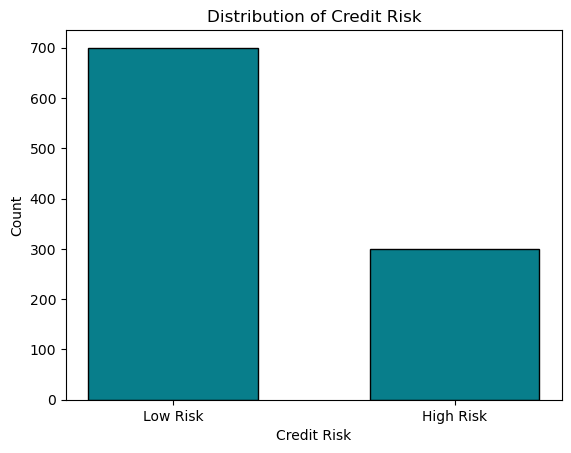

In [67]:
plt.bar(x = y.value_counts().index , height = y.value_counts().values, 
        width = 0.6, 
        color = '#087E8B',
        edgecolor = 'black')
plt.xlabel(xlabel = 'Credit Risk')
plt.ylabel(ylabel = 'Count')
plt.title(label = 'Distribution of Credit Risk')

file_path = os.path.join(figures_folder, 'Target_variable_distribution.png')
plt.savefig(file_path)

plt.show();

There is a 70/30 split between low-risk and high-risk individuals, indicating an unbalanced dataset. According to the data documentation, misclassifying high-risk individuals as low-risk should incur a higher penalty compared to misclassifying low-risk individuals as high-risk. This imbalance will be addressed when developing the models.

### 4.2.3 Univariate Analysis

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CheckingAccountStatus   1000 non-null   object
 1   LoanDurationMonths      1000 non-null   int64 
 2   CreditHistory           1000 non-null   object
 3   LoanPurpose             1000 non-null   object
 4   CreditAmount            1000 non-null   int64 
 5   SavingsAccountBonds     1000 non-null   object
 6   EmploymentDuration      1000 non-null   object
 7   InstallmentRate         1000 non-null   int64 
 8   PersonalStatusSex       1000 non-null   object
 9   OtherDebtorsGuarantors  1000 non-null   object
 10  ResidenceDuration       1000 non-null   int64 
 11  PropertyOwnership       1000 non-null   object
 12  AgeYears                1000 non-null   int64 
 13  OtherInstallmentPlans   1000 non-null   object
 14  HousingStatus           1000 non-null   object
 15  Exist

#### 4.2.3.1 Numerical Variables

The following will be an assessment of the numerical features of the dataset, with the purpose of identifying skewness, outliers, or unusual distributions. A function will be created to generate histograms more easily. The bar_graph() function will be used for quantitative attributes with discrete values.

In [69]:
def histo(X: pd.Series, title: str = '', xlabel: str = '', ylabel: str = '', filename: str = '', **kwargs):
    '''Display a density histogram overlaid with a PDF curve for a normal distribution. Optionally save the figure.'''
    # Plot histogram
    # plt.figure(figsize=(12,8))
    plt.hist(x = X, bins = 20, color = kwargs.get('color', '#087E8B'), edgecolor = 'black', density = True)

    # Fit normal distribution
    mu, std = norm.fit(X)  # Mean and standard deviation
    xmin, xmax = plt.xlim()
    x = np.linspace(start=xmin, stop=xmax, num=100)
    p = norm.pdf(x, mu, std)  # PDF for normal distribution

    # Plot normal distribution curve
    plt.plot(x, p, 'k', linewidth=2)

    # Title and labels
    plt.xlabel(xlabel if xlabel else 'X-axis')
    plt.ylabel(ylabel if ylabel else 'Density')
    plt.title(title if title else 'Histogram with Normal PDF')

    # Add text box for mean and standard deviation
    plt.figtext(
        x = kwargs.get('figtext_x', 0.75),
        y = kwargs.get('figtext_y', 0.815),
        s = f'Mean: {mu:.2f} \nSD: {std:.2f}',
        fontsize = 10,
        bbox=dict(
            boxstyle = kwargs.get('boxstyle', 'square'),
            facecolor = kwargs.get('facecolor', 'lightblue'),
            edgecolor = kwargs.get('edgecolor', 'black'),
            alpha = kwargs.get('alpha', 1)
        )
    )

    # Save the figure if filename is provided
    if filename:
        # Ensure the output folder exists
        figures_folder = os.path.join(os.getcwd(), 'outputs', 'visuals')
        os.makedirs(figures_folder, exist_ok=True)  # Create the folder if it doesn't exist

        # Build full path and save the figure
        full_path = os.path.join(figures_folder, filename)
        plt.savefig(full_path, bbox_inches='tight')
        # print(f"Figure saved as {full_path}") Remove this to indicate whether or not file was saved

    plt.show()




In [70]:
def bar_graph(X: pd.Series, title: str = '', xlabel: str = '', ylabel: str = '', filename: str = '', **kwargs):
    '''Display a bar graph for a pd.Series. Optionally saves the figure.'''
    
    # Plot Bar
    # plt.figure(figsize=(12,8))
    plt.bar(x = X.value_counts().index, 
            height = X.value_counts().values, 
            color = kwargs.get('color', '#087E8B'), 
            edgecolor = kwargs.get('edgecolor', 'black'))
    
    # Labels and titles
    plt.xlabel(xlabel if xlabel else 'X-axis')
    plt.ylabel(ylabel if ylabel else 'Count')
    plt.title(title if title else 'Bar Plot')

    # Ticks marks
    plt.xticks(ticks=X.value_counts().index, 
               labels = kwargs.get('labels', X.value_counts().index))
    
    if kwargs.get('yticks'):  # Only set yticks if explicitly provided
        plt.yticks(ticks = kwargs['yticks'])

    # Save the figure if filename is provided
    if filename:
        # Ensure the output folder exists
        figures_folder = os.path.join(os.getcwd(), 'outputs', 'visuals')
        os.makedirs(figures_folder, exist_ok=True)  # Create the folder if it doesn't exist

        # Build full path and save the figure
        full_path = os.path.join(figures_folder, filename)
        plt.savefig(full_path, bbox_inches='tight')
        # print(f"Figure saved as {full_path}") Remove to confirm confirmation of save

    plt.show()


##### 4.2.3.1.1. LoanDurationMonths

In [71]:
X['LoanDurationMonths'].describe()

count   1000.000000000
mean      20.903000000
std       12.058814453
min        4.000000000
25%       12.000000000
50%       18.000000000
75%       24.000000000
max       72.000000000
Name: LoanDurationMonths, dtype: float64

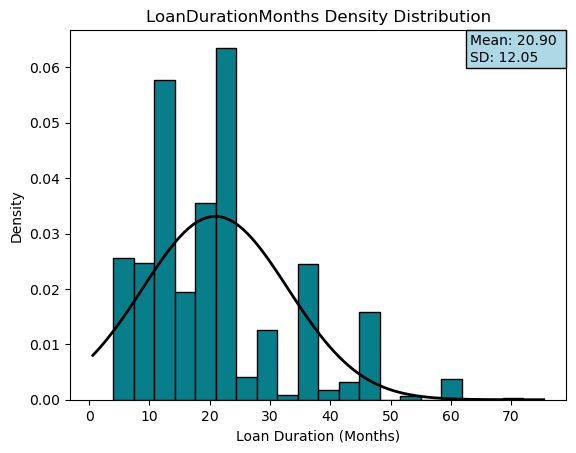

In [72]:
histo(X['LoanDurationMonths'], 
      xlabel = 'Loan Duration (Months)', 
      ylabel = 'Density', 
      title = 'LoanDurationMonths Density Distribution',
      filename = 'LonaDurationMonths_Distribution.png')

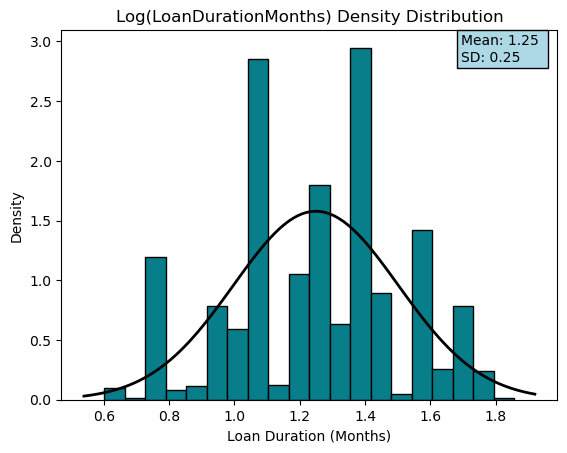

In [73]:
histo(np.log10(X['LoanDurationMonths']), 
      xlabel = 'Loan Duration (Months)', 
      ylabel = 'Density', 
      title = 'Log(LoanDurationMonths) Density Distribution',
      filename = 'LogLoanDurationMonths_Distribution.png')

The log transformation appears to approve the symmetry and follows a normal distribution much closer compared to the untransformed *LoanDurationMonths*.

##### 4.2.3.1.2. CreditAmount

In [74]:
X['CreditAmount'].describe()

count    1000.000000000
mean     3271.258000000
std      2822.736875960
min       250.000000000
25%      1365.500000000
50%      2319.500000000
75%      3972.250000000
max     18424.000000000
Name: CreditAmount, dtype: float64

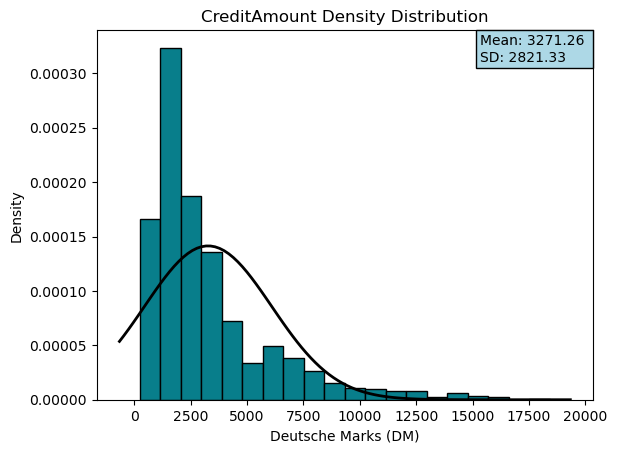

In [75]:
histo(X=X['CreditAmount'],
      xlabel='Deutsche Marks (DM)',
      ylabel='Density',
      title='CreditAmount Density Distribution',
      figtext_x = 0.724,
      filename = 'CreditAmount_DensityDistribution')


*CreditAmount* displays heavy right skew.

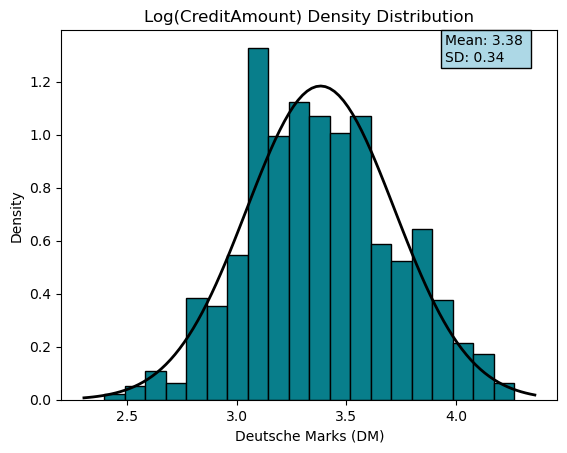

In [76]:
histo(X =  np.log10(X['CreditAmount']),
      xlabel = 'Deutsche Marks (DM)',
      ylabel = 'Density',
      title = 'Log(CreditAmount) Density Distribution',
      figtext_x = 0.724,
      filename = 'LogCreditAmount_DensityDistribution')

A log transformation of *CreditAmount* provides a much more normal distribution.

##### 4.2.3.1.3. InstallmentRate

In [77]:
X['InstallmentRate'].describe()

count   1000.000000000
mean       2.973000000
std        1.118714674
min        1.000000000
25%        2.000000000
50%        3.000000000
75%        4.000000000
max        4.000000000
Name: InstallmentRate, dtype: float64

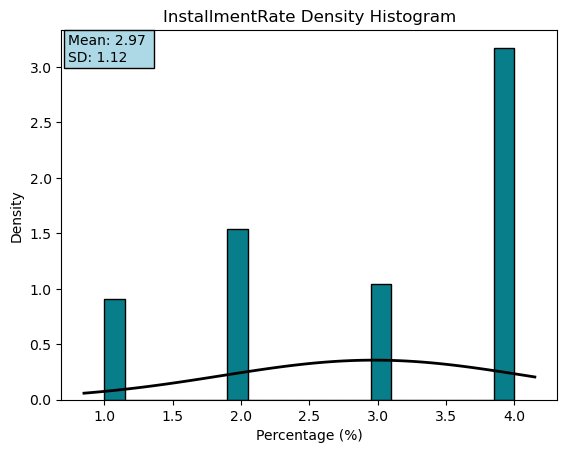

In [78]:
histo(X = X['InstallmentRate'],
      xlabel = 'Percentage (%)',
      ylabel = 'Density',
      title = 'InstallmentRate Density Histogram',
      filename = 'InstallmentRate_DensityHistogram',
      figtext_x = 0.135)

A majority of German individuals have an installment rate equal to 4% of their disposable income.

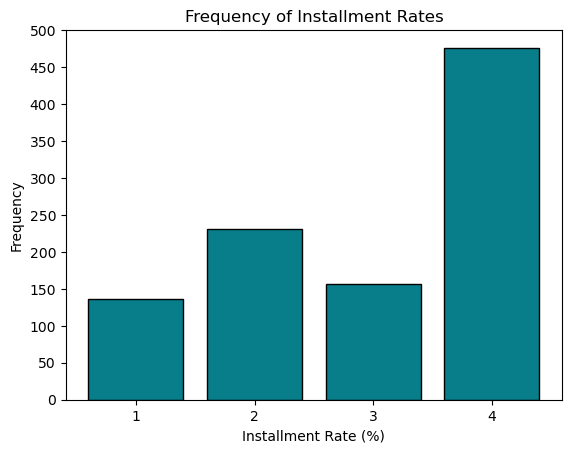

In [79]:
bar_graph(X = X['InstallmentRate'],
          xlabel = 'Installment Rate (%)',
          ylabel = 'Frequency',
          title = 'Frequency of Installment Rates',
          yticks = list(range(0, 550, 50)),
          filename = 'InstallmentRate_Bar.png')

##### 4.2.3.1.4. ResidenceDuration 

In [80]:
X['ResidenceDuration'].describe()

count   1000.000000000
mean       2.845000000
std        1.103717896
min        1.000000000
25%        2.000000000
50%        3.000000000
75%        4.000000000
max        4.000000000
Name: ResidenceDuration, dtype: float64

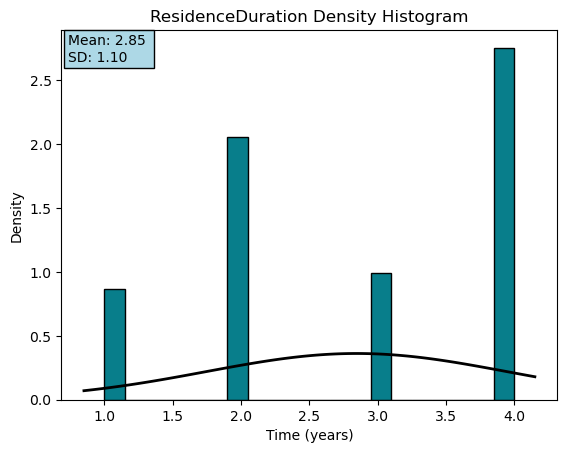

In [81]:
histo(X = X['ResidenceDuration'],
      xlabel = 'Time (years)',
      ylabel = 'Density',
      title = 'ResidenceDuration Density Histogram',
      filename = 'ResidenceDuration_DensityHistogram',
      figtext_x = 0.135)

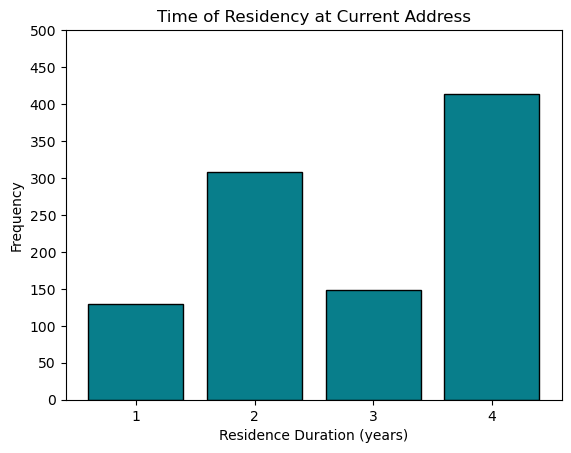

In [82]:
bar_graph(X = X['ResidenceDuration'],
          xlabel = 'Residence Duration (years)',
          ylabel = 'Frequency',
          title = 'Time of Residency at Current Address',
          yticks = list(range(0, 550, 50)),
          filename = 'ResidenceDuration_Bar.png')

##### 4.2.3.1.5. AgeYears

In [83]:
X['AgeYears'].describe()

count   1000.000000000
mean      35.546000000
std       11.375468574
min       19.000000000
25%       27.000000000
50%       33.000000000
75%       42.000000000
max       75.000000000
Name: AgeYears, dtype: float64

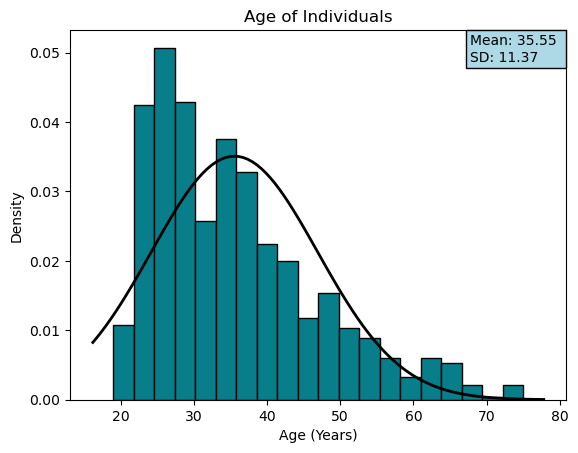

In [84]:
histo(X = X['AgeYears'],
      xlabel = 'Age (Years)',
      title = 'Age of Individuals',
      filename = 'AgeYears_Distribution.png')

*AgeYears* is slighly right-skewed toward older individuals

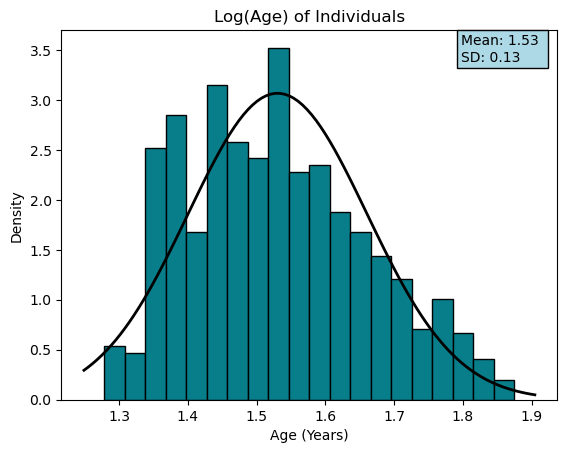

In [85]:
histo(X = np.log10(X['AgeYears']),
      xlabel = 'Age (Years)',
      title = 'Log(Age) of Individuals',
      filename = 'LOgAgeYears_Distribution.png')

Log transformation of *Age* creates a normal looking distribution.

##### 4.2.3.1.6. ExistingCredits

In [86]:
X['ExistingCredits'].describe()

count   1000.000000000
mean       1.407000000
std        0.577654468
min        1.000000000
25%        1.000000000
50%        1.000000000
75%        2.000000000
max        4.000000000
Name: ExistingCredits, dtype: float64

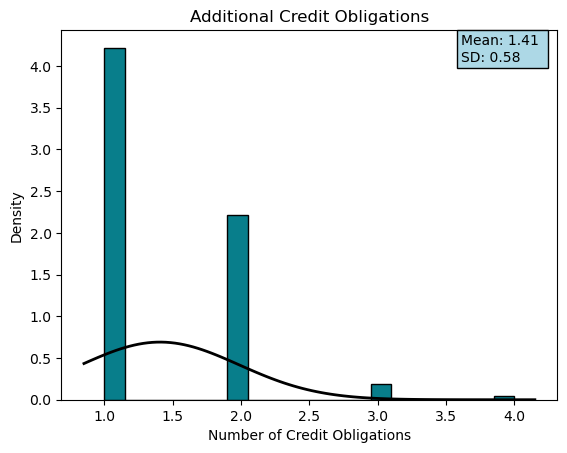

In [87]:
histo(X = X['ExistingCredits'],
      xlabel = 'Number of Credit Obligations',
      title = 'Additional Credit Obligations',
      filename = 'ExistingCredit_histogram.png')

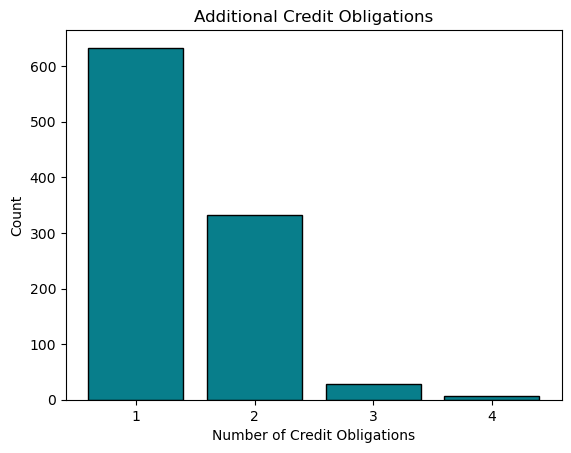

In [88]:
bar_graph(X = X['ExistingCredits'],
          xlabel = 'Number of Credit Obligations',
          title = 'Additional Credit Obligations',
          filename = 'ExistingCredit_bar.png')

A vast majority of individuals appear to have only 1 or 2 additional credit obligations with their bank.

##### 4.2.3.1.7. Dependents

In [89]:
X['Dependents'].describe()

count   1000.000000000
mean       1.155000000
std        0.362085772
min        1.000000000
25%        1.000000000
50%        1.000000000
75%        1.000000000
max        2.000000000
Name: Dependents, dtype: float64

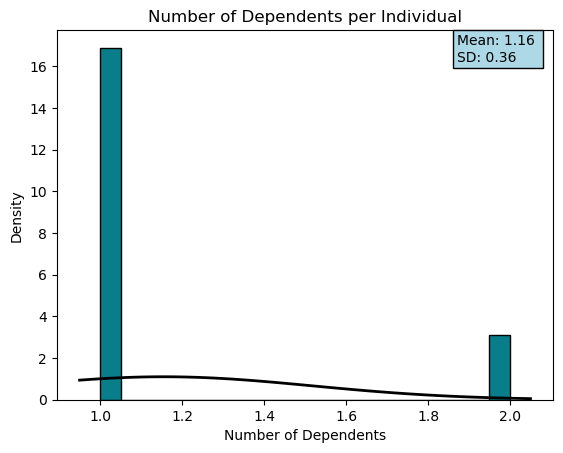

In [90]:
histo(X = X['Dependents'],
      xlabel = 'Number of Dependents',
      title = 'Number of Dependents per Individual',
      filename = 'Dependents_histogram.png')

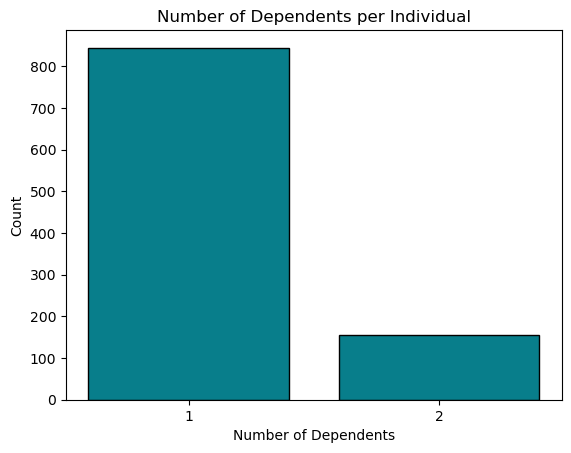

In [91]:
bar_graph(X = X['Dependents'],
          xlabel = 'Number of Dependents',
          title = 'Number of Dependents per Individual',
          filename = 'Dependents_bar.png')

Most individuals within the dataset only have 1 dependent

#### 4.2.3.2. Categorical Features

The following will be an assessment of the categorical features of the dataset, with the purpose of distributions and imbalances within the attributes.

##### 4.2.3.2.1. CheckingAccountStatus

In [92]:
X['CheckingAccountStatus'].describe()

count                    1000
unique                      4
top       No checking account
freq                      394
Name: CheckingAccountStatus, dtype: object

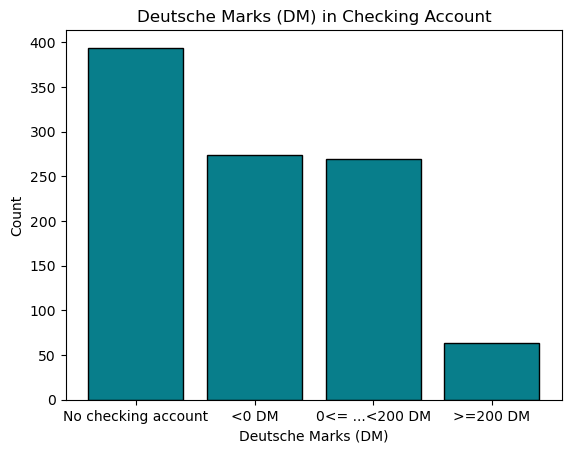

In [93]:
bar_graph(X = X['CheckingAccountStatus'],
          title = 'Deutsche Marks (DM) in Checking Account',
          xlabel = 'Deutsche Marks (DM)',
          filename = 'CheckingAccount_bar.png')

##### 4.2.3.2.2. CreditHistory

In [94]:
X['CreditHistory'].describe()

count               1000
unique                 5
top       Good repayment
freq                 530
Name: CreditHistory, dtype: object

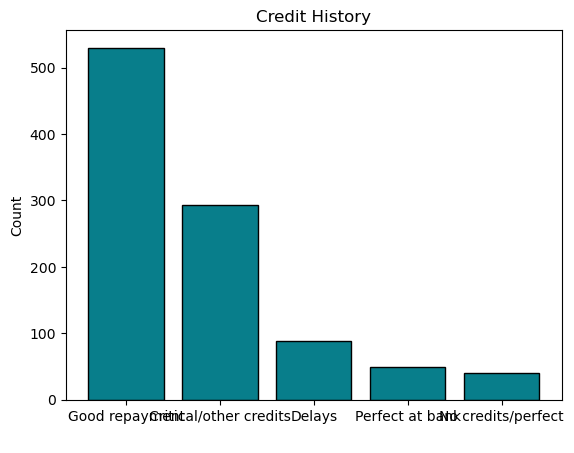

In [95]:
bar_graph(X = X['CreditHistory'],
          title = 'Credit History',
          xlabel = ' ',
          filename = 'CreditHistory_bar.png')

Most individuals appear to repay their loans and credits without issue.

##### 4.2.3.2.3. LoanPurpose

In [96]:
X['LoanPurpose'].describe()

count         1000
unique          10
top       Radio/TV
freq           280
Name: LoanPurpose, dtype: object

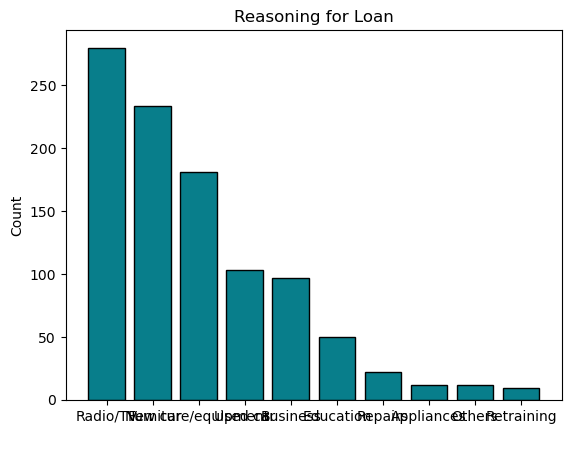

In [97]:
bar_graph(X = X['LoanPurpose'],
          title = 'Reasoning for Loan',
          xlabel = ' ',
          filename = 'LoanPurpose_bar.png')

##### 4.2.3.2.4. SavingsAccountBonds

In [98]:
X['SavingsAccountBonds'].describe()

count        1000
unique          5
top       <100 DM
freq          603
Name: SavingsAccountBonds, dtype: object

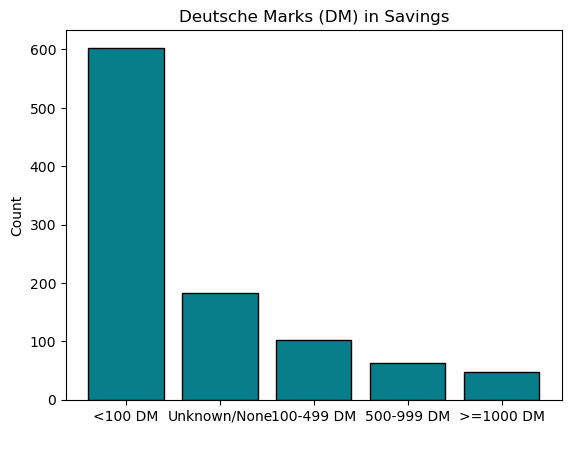

In [99]:
bar_graph(X = X['SavingsAccountBonds'],
          title = 'Deutsche Marks (DM) in Savings',
          xlabel = ' ',
          filename = 'SavingsAccountBonds_bar.png')

Vast majority of invidiuals have less than <100 DM or no savings.

##### 4.2.3.2.5. EmploymentDuration 

In [100]:
X['EmploymentDuration'].describe()

count          1000
unique            5
top       1-3 years
freq            339
Name: EmploymentDuration, dtype: object

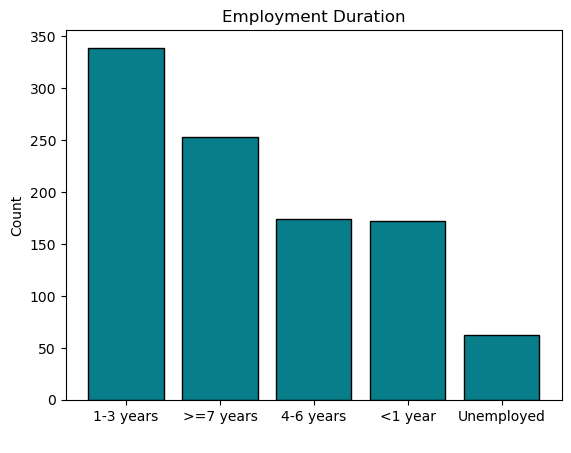

In [101]:
bar_graph(X = X['EmploymentDuration'],
          title = 'Employment Duration',
          xlabel = ' ',
          filename = 'EmploymentDuration_bar.png')

##### 4.2.3.2.6. PersonalStatusSex

In [102]:
X['PersonalStatusSex'].describe()

count             1000
unique               4
top       Male: single
freq               548
Name: PersonalStatusSex, dtype: object

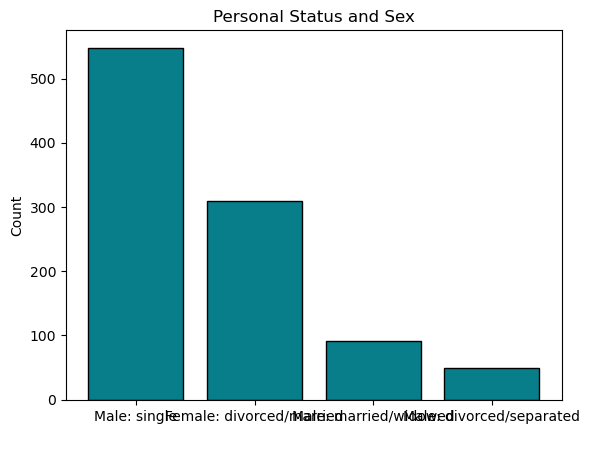

In [103]:
bar_graph(X = X['PersonalStatusSex'],
          title = 'Personal Status and Sex',
          xlabel = ' ',
          filename = 'PersonalStatusSex_bar.png')

Dataset is heavily skewed toward men.

##### 4.2.3.2.7. OtherDebtorsGuarantors 

In [104]:
X['OtherDebtorsGuarantors'].describe()

count     1000
unique       3
top       None
freq       907
Name: OtherDebtorsGuarantors, dtype: object

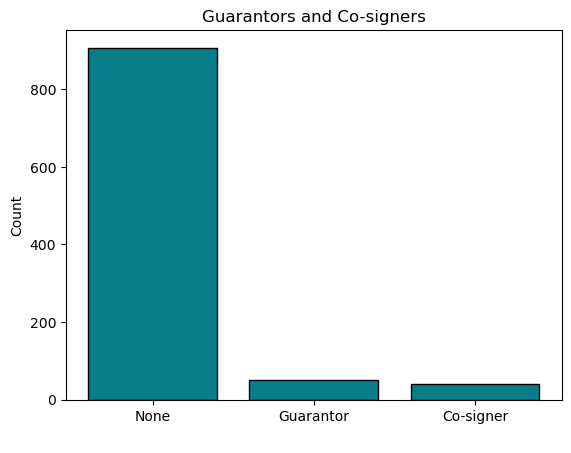

In [105]:
bar_graph(X = X['OtherDebtorsGuarantors'],
          title = 'Guarantors and Co-signers',
          xlabel = ' ',
          filename = 'OtherDebtorsGuarantors_bar.png')

Most individuals do not have a Guarantor or Co-signer.

##### 4.2.3.2.8. PropertyOwnership  

In [106]:
X['PropertyOwnership'].describe()

count                   1000
unique                     4
top       Car/other property
freq                     332
Name: PropertyOwnership, dtype: object

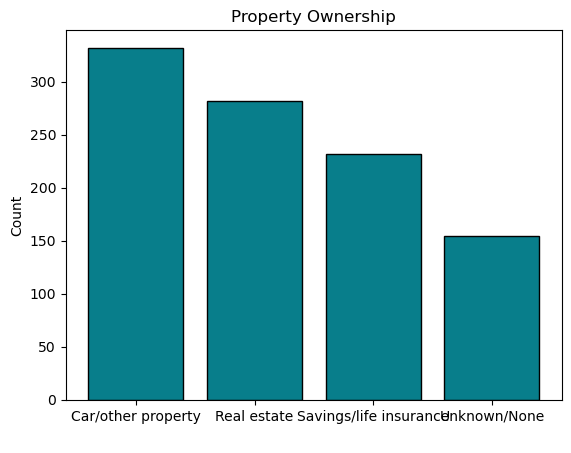

In [107]:
bar_graph(X = X['PropertyOwnership'],
          title = 'Property Ownership',
          xlabel = ' ',
          filename = 'PropertyOwnership_bar.png')

##### 4.2.3.2.8. OtherInstallmentPlans

In [108]:
X['OtherInstallmentPlans'].describe()

count     1000
unique       3
top       None
freq       814
Name: OtherInstallmentPlans, dtype: object

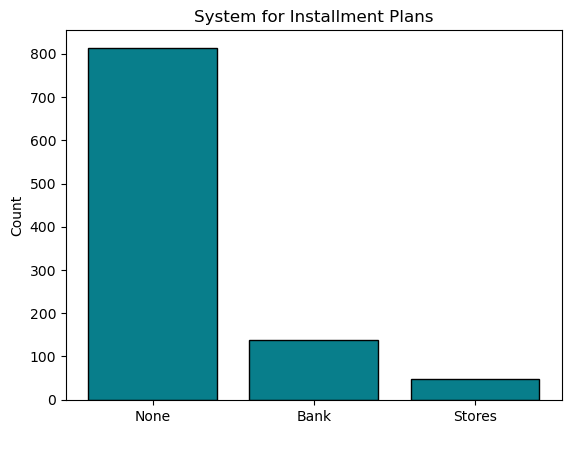

In [109]:
bar_graph(X = X['OtherInstallmentPlans'],
          title = 'System for Installment Plans',
          xlabel = ' ',
          filename = 'OtherInstallmentPlans_bar.png')

##### 4.2.3.2.9. HousingStatus 

In [110]:
X['HousingStatus'].describe()

count     1000
unique       3
top        Own
freq       713
Name: HousingStatus, dtype: object

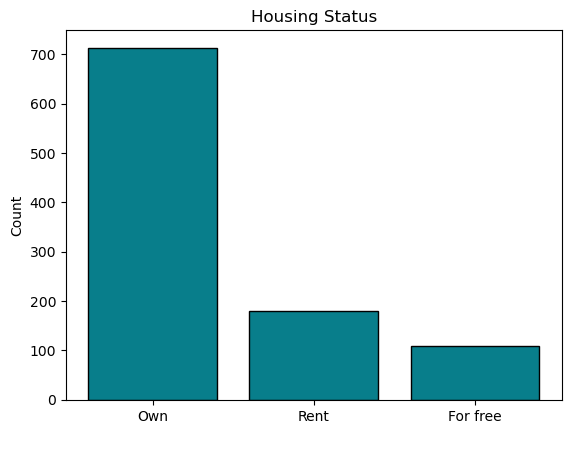

In [111]:
bar_graph(X = X['HousingStatus'],
          title = 'Housing Status',
          xlabel = ' ',
          filename = 'HousingStatus_bar.png')

##### 4.2.3.2.10. JobType

In [112]:
X['JobType'].describe()

count                 1000
unique                   4
top       Skilled employee
freq                   630
Name: JobType, dtype: object

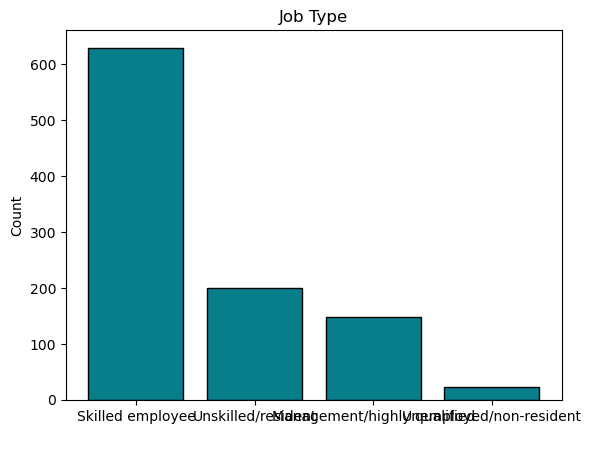

In [113]:
bar_graph(X = X['JobType'],
          title = 'Job Type',
          xlabel = ' ',
          filename = 'JobType_bar.png')

##### 4.2.3.2.11. Telephone

In [114]:
X['Telephone'].describe()

count     1000
unique       2
top       None
freq       596
Name: Telephone, dtype: object

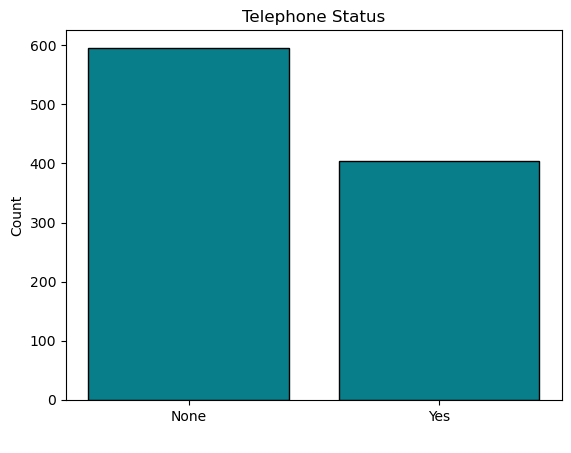

In [115]:
bar_graph(X = X['Telephone'],
          title = 'Telephone Status',
          xlabel = ' ',
          filename = 'Telephone_bar.png')

Suprisingly many individuals do not own a telephone.

##### 4.2.3.2.12. ForeignWorker

In [116]:
X['ForeignWorker'].describe()

count     1000
unique       2
top        Yes
freq       963
Name: ForeignWorker, dtype: object

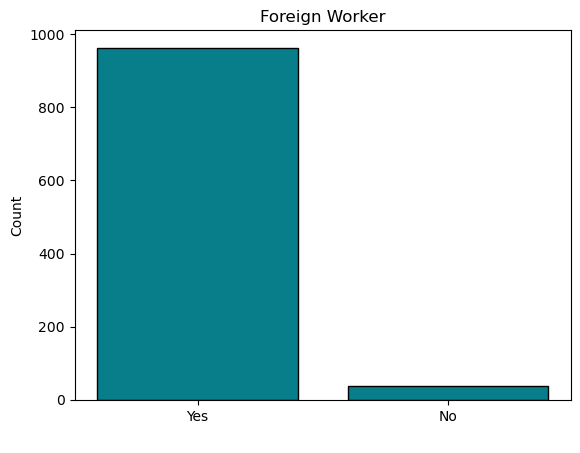

In [117]:
bar_graph(X = X['ForeignWorker'],
          title = 'Foreign Worker',
          xlabel = ' ',
          filename = 'ForeignWorker_bar.png')

The vast majority of Germans are citizens.

### 4.2.4. Bivariate Analysis

In [118]:
df = X.copy()
df['CreditRisk'] = y
df.head()

,CheckingAccountStatus,LoanDurationMonths,CreditHistory,LoanPurpose,CreditAmount,SavingsAccountBonds,EmploymentDuration,InstallmentRate,PersonalStatusSex,OtherDebtorsGuarantors,...,PropertyOwnership,AgeYears,OtherInstallmentPlans,HousingStatus,ExistingCredits,JobType,Dependents,Telephone,ForeignWorker,CreditRisk
0,<0 DM,6,Critical/other credits,Radio/TV,1169,Unknown/None,>=7 years,4,Male: single,None,...,Real estate,67,None,Own,2,Skilled employee,1,Yes,Yes,Low Risk
1,0<= ...<200 DM,48,Good repayment,Radio/TV,5951,<100 DM,1-3 years,2,Female: divorced/married,None,...,Real estate,22,None,Own,1,Skilled employee,1,None,Yes,High Risk
2,No checking account,12,Critical/other credits,Education,2096,<100 DM,4-6 years,2,Male: single,None,...,Real estate,49,None,Own,1,Unskilled/resident,2,None,Yes,Low Risk
3,<0 DM,42,Good repayment,Furniture/equipment,7882,<100 DM,4-6 years,2,Male: single,Guarantor,...,Savings/life insurance,45,None,For free,1,Skilled employee,2,None,Yes,Low Risk
4,<0 DM,24,Delays,New car,4870,<100 DM,1-3 years,3,Male: single,None,...,Unknown/None,53,None,For free,2,Skilled employee,2,None,Yes,High Risk


#### 4.2.4.1. Numerical Variables

A function will be created to streamline the creation of boxplots and bargraphs

In [119]:
def boxplot(data: pd.DataFrame, x: str, y: str, title :str = '', xlabel: str = '', ylabel:str = '', filename:str = '', orient: str = '', **kwargs):
    '''Function to create a boxplot based on a categorical variable. Optionally saves the figure'''
    boxplot_params = {'data': data,
                      'x': x,
                      'y': y,
                      'notch': kwargs.get('notch', True),
                      'color': kwargs.get('color', '#087E8B'),
                      'width': kwargs.get('width', 0.5)}
    
    if orient:
        boxplot_params['orient'] = orient
    
    # Plot boxplot
    ax = sns.boxplot(**boxplot_params)
    
    # Set title
    if title:
        ax.set_title(title)

    # Set x and y labels
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)
    
    
    if 'xticklabels' in kwargs:
        ax.set_xticklabels(kwargs['xticklabels'], rotation=kwargs.get('xtick_rotation', 0))

    # Save the figure if filename is provided
    if filename:
        # Ensure the output folder exists
        figures_folder = os.path.join(os.getcwd(), 'outputs', 'visuals')
        os.makedirs(figures_folder, exist_ok=True)  # Create the folder if it doesn't exist

        # Build full path and save the figure
        full_path = os.path.join(figures_folder, filename)
        plt.savefig(full_path, bbox_inches='tight')
        # print(f"Figure saved as {full_path}") Remove this to indicate whether or not file was saved

    plt.show()
    plt.close()


In [120]:
def bar_graph(data: pd.DataFrame, x: str, title: str = '', xlabel: str = '', ylabel: str = '', filename: str = '', hue: str = '', **kwargs):
    '''Function to create a bar graph for a categorical variable. Optionally saves the figure.'''
    
    barplot_params = {'data': data,
                      'x': x,
                      'hue': hue if hue else None,  # Allows for grouping by a categorical variable
                      'palette': kwargs.get('palette', 'Blues'),
                      'edgecolor': kwargs.get('edgecolor', 'black')}
    
    # Plot bar graph
    ax = sns.countplot(**barplot_params)

    # Set title
    if title:
        ax.set_title(title)

    # Set x and y labels
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else 'Count')

    # Adjust x-tick labels if provided
    if 'xticklabels' in kwargs:
        ax.set_xticklabels(kwargs['xticklabels'], rotation=kwargs.get('xtick_rotation', 0))

    # Fix 
    plt.xticks(rotation=kwargs.get('xtick_rotation', 45), ha='right')

    # Save the figure if filename is provided
    if filename:
        # Ensure the output folder exists
        figures_folder = os.path.join(os.getcwd(), 'outputs', 'visuals')
        os.makedirs(figures_folder, exist_ok=True)  # Create the folder if it doesn't exist

        # Build full path and save the figure
        full_path = os.path.join(figures_folder, filename)
        plt.savefig(full_path, bbox_inches='tight')
        # print(f"Figure saved as {full_path}") Remove this to indicate whether or not file was saved

    plt.show()
    plt.close()


##### 4.2.4.1.1. LoanDurationMonths and CreditRisk

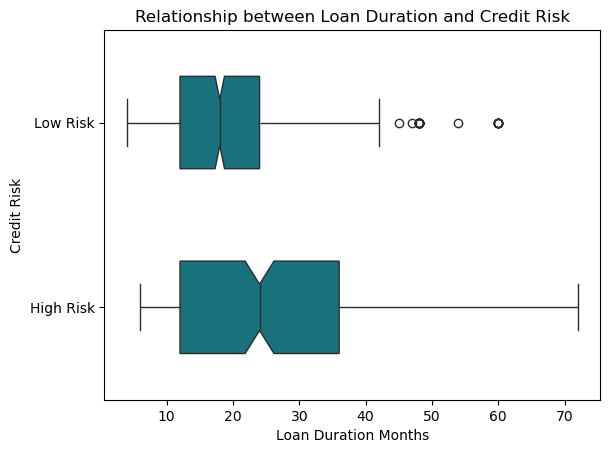

In [121]:
boxplot(data = df, 
        x = 'LoanDurationMonths', 
        y = 'CreditRisk', 
        xlabel = 'Loan Duration Months',
        ylabel = 'Credit Risk',
        title = 'Relationship between Loan Duration and Credit Risk',
        filename = 'LoanDuration_CreditRisk_boxplot.png')

Longer loan durations appear to be signficantly associated with higher credit risk potentially due to increased uncertainty over extended periods.

##### 4.2.3.1.2. CreditAmount and CreditRisk

*CreditAmount* represents the total amount of money requested or approved for a loan. Higher credit amounts could be associated with higher credit risk, as larger loans may be harder to repay.

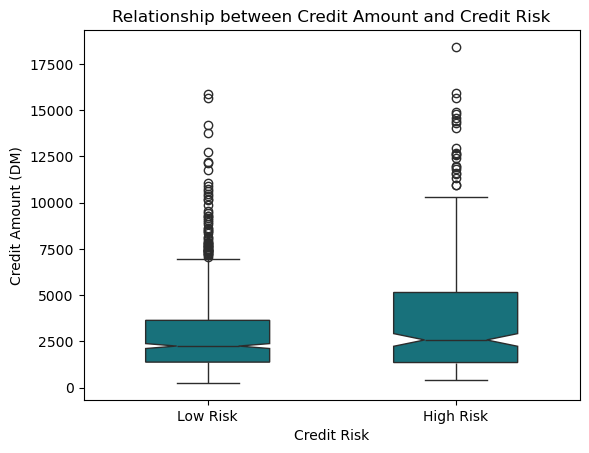

In [122]:
boxplot(data = df, 
        x = 'CreditRisk', 
        y = 'CreditAmount', 
        xlabel = 'Credit Risk', 
        ylabel = 'Credit Amount (DM)', 
        title = 'Relationship between Credit Amount and Credit Risk', 
        filename = 'CreditAmount_CreditRisk_boxplot.png')

There doesn't appear to be a signficant difference in the median between the groups, but higher credit amounts appear to be associated with higher risk. 

##### 4.2.3.1.3. InstallmentRate and CreditRisk

*InstallmentRate* represents the proportion of a borrower's disposable income allocated to loan repayments, measured as a percentage. A higher installment rate could indicate greater financial burden, potentially increasing credit risk.

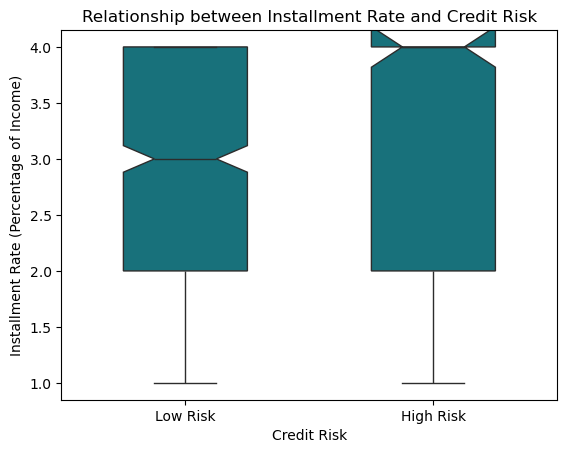

In [123]:
boxplot(data = df, 
        x = 'CreditRisk', 
        y = 'InstallmentRate', 
        xlabel = 'Credit Risk', 
        ylabel = 'Installment Rate (Percentage of Income)', 
        title = 'Relationship between Installment Rate and Credit Risk', 
        filename = 'InstallmentRate_CreditRisk_boxplot.png')

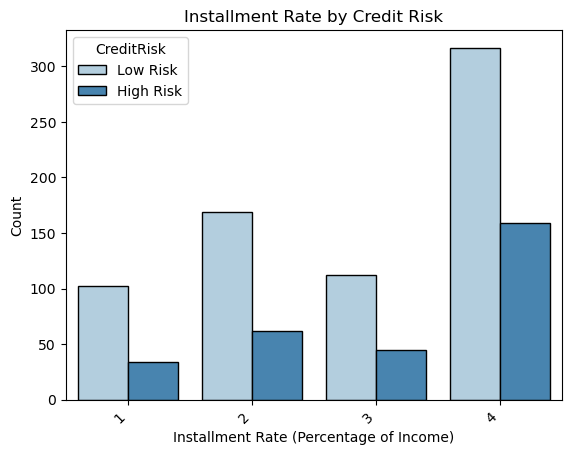

In [124]:
bar_graph(data = df, 
          x = 'InstallmentRate', 
          hue = 'CreditRisk', 
          title = 'Installment Rate by Credit Risk', 
          xlabel = 'Installment Rate (Percentage of Income)', 
          filename = 'InstallmentRate_CreditRisk_barplot.png')

The majority of individuals fall into the Installment Rate categories of 3 and 4, and a significant proportion of high-risk borrowers take on relatveily high financial commitments. Borrowers who spend a lower percentage of their income (1 or 2) on loan payments are more likely to be classified as Low Risk. However, there are still some high-risk borrowers with Installment Rates of 1 and 2, indicating that installment rate may not be a useful factor determining credit risk.

##### 4.2.3.1.4. ResidenceDuration and CreditRisk

*ResidenceDuration* represents the number of years a borrower has lived at their current residence. Longer residence duration may indicate financial stability and reliability, potentially correlating with lower credit risk.

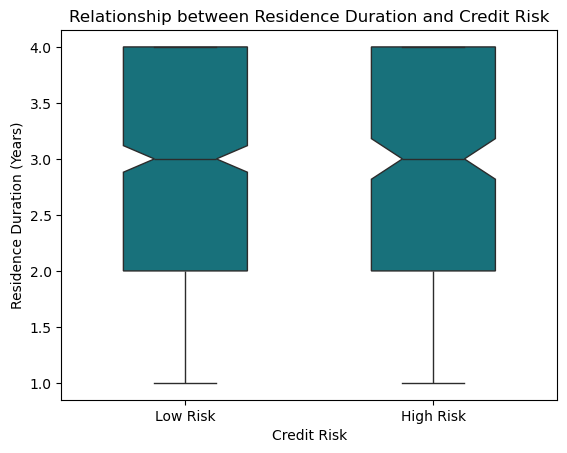

In [125]:
boxplot(data = df, 
        x = 'CreditRisk', 
        y = 'ResidenceDuration', 
        xlabel = 'Credit Risk', 
        ylabel = 'Residence Duration (Years)', 
        title = 'Relationship between Residence Duration and Credit Risk', 
        filename = 'ResidenceDuration_CreditRisk_boxplot.png')

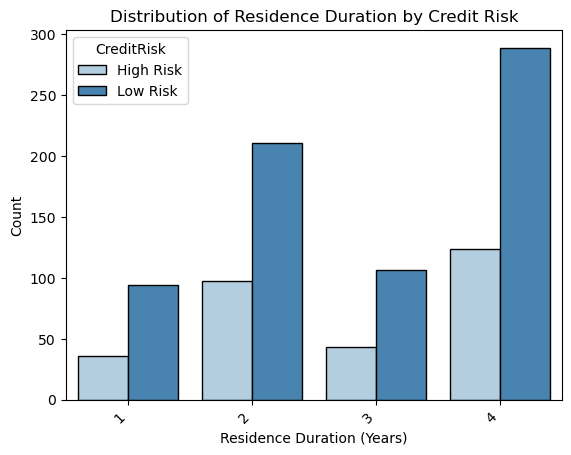

In [126]:
bar_graph(data = df, 
          x = 'ResidenceDuration', 
          hue = 'CreditRisk', 
          xlabel = 'Residence Duration (Years)', 
          ylabel = 'Count', 
          title = 'Distribution of Residence Duration by Credit Risk', 
          filename = 'ResidenceDuration_CreditRisk_barplot.png')

The largest group of Low Risk borrowers has a Residence Duration of 4 years. High risk borrowers appear to follow no discernible pattern. 

##### 4.2.3.1.5. AgeYears and CreditRisk

*AgeYears* represents the borrower's age in years. Older individuals may have more financial stability and a longer credit history, potentially reducing their credit risk. Younger borrowers might be considered riskier due to limited financial history and potential income instability.

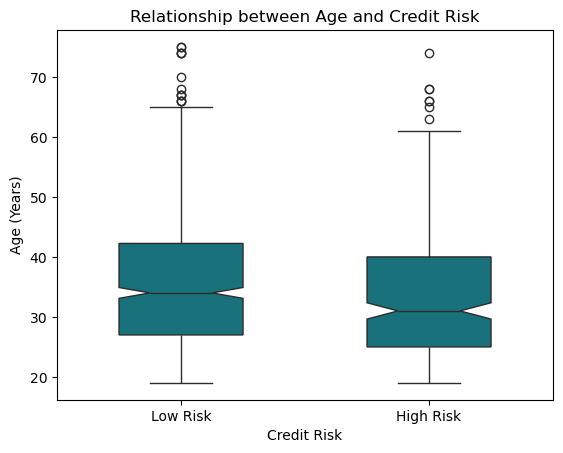

In [127]:
boxplot(data = df, 
        x = 'CreditRisk', 
        y = 'AgeYears', 
        xlabel = 'Credit Risk', 
        ylabel = 'Age (Years)', 
        title = 'Relationship between Age and Credit Risk', 
        filename = 'AgeYears_CreditRisk_boxplot.png')

OLder individuals tend to have slighly lower credit risk, but the difference is not significant. 

##### 4.2.3.1.6. ExistingCredits and CreditRisk

*ExistingCredits* represents the number of active credit accounts or loans a borrower currently holds. Borrowers with more existing credits may have higher financial obligations, potentially leading to higher credit risk. However, responsible borrowers with multiple credit lines may still maintain a low risk if they have good repayment history.

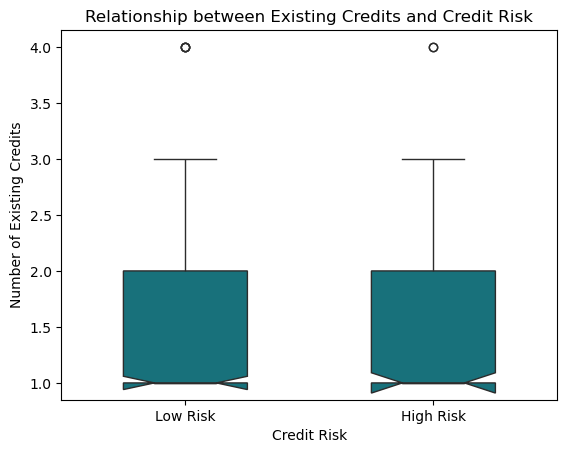

In [128]:
boxplot(data = df, 
        x = 'CreditRisk', 
        y = 'ExistingCredits', 
        xlabel = 'Credit Risk', 
        ylabel = 'Number of Existing Credits', 
        title = 'Relationship between Existing Credits and Credit Risk', 
        filename = 'ExistingCredits_CreditRisk_boxplot.png')

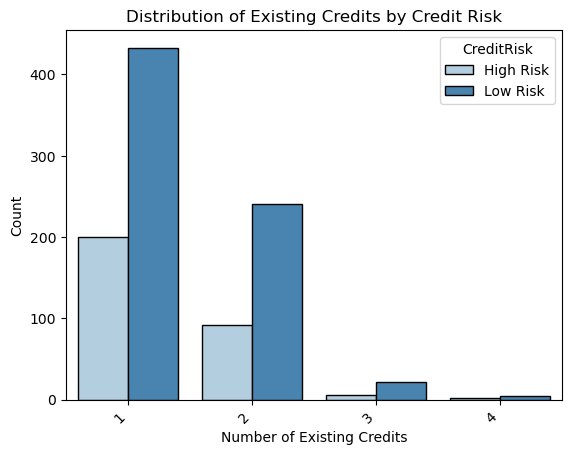

In [129]:
bar_graph(data = df, 
          x = 'ExistingCredits', 
          hue = 'CreditRisk', 
          xlabel = 'Number of Existing Credits', 
          ylabel = 'Count', 
          title = 'Distribution of Existing Credits by Credit Risk', 
          filename = 'ExistingCredits_CreditRisk_barplot.png')

The majority of borrowers have either 1 or 2 existing credit accounts, and there a very few individuals with 3 or 4 credit cards. Low-risk borrowers outnumber high-risk borrowers in all groups. However, the proportion of high-risk borrowers increases slightly as the number of credits increases.

#### 4.2.4.2. Categorical Variables

##### 4.2.3.2.1. CheckingAccountStatus and CreditRisk

*CheckingAccountStatus* represents the status of the borrower's existing checking account, categorized into different financial tiers.  Borrowers with no checking account or very low balances may have a higher credit risk, while those with a larger savings may be lower risk.

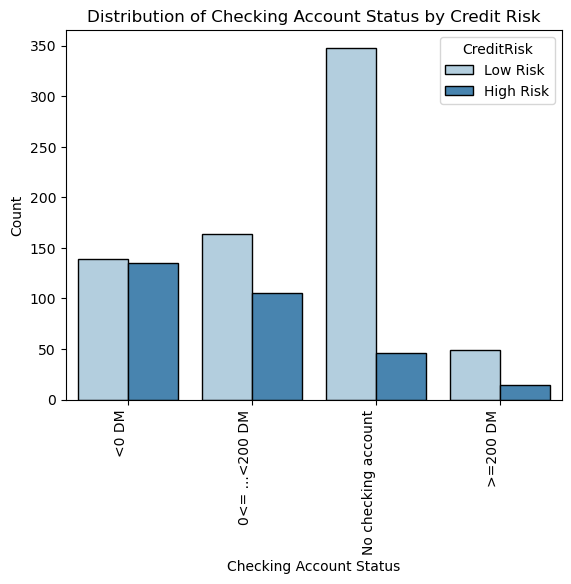

In [130]:
bar_graph(data = df, 
          x = 'CheckingAccountStatus', 
          hue = 'CreditRisk', 
          xlabel = 'Checking Account Status', 
          ylabel = 'Count', 
          title = 'Distribution of Checking Account Status by Credit Risk', 
          filename = 'CheckingAccountStatus_CreditRisk_barplot.png',
          xtick_rotation = 90)

The largest group in the dataset consists of borrowers with no checking account. This suggests that not having a checking account does not necessarily indicate high credit risk, which goes against expectations. Borrowers with negative balances (< 0 DM) or low balances (0 <= ... < 200 DM) are evenly split between Low Risk and High Risk indicating that low checking account balacnes are not strong indicators of credit risk. Borrowers with high balances are mostly low risk, alinging with expectations. 

##### 4.2.3.2.2. CreditHistory and CreditRisk

*CreditHistory* represents the borrower's past repayment behavior, including whether they have duly paid back previous loans, experienced delays, or defaulted. It is expected that borrowers with a history of delays or outstanding debts are more likely to be classified as High Risk, while those with perfect or good credit history should be predominantly Low Risk.

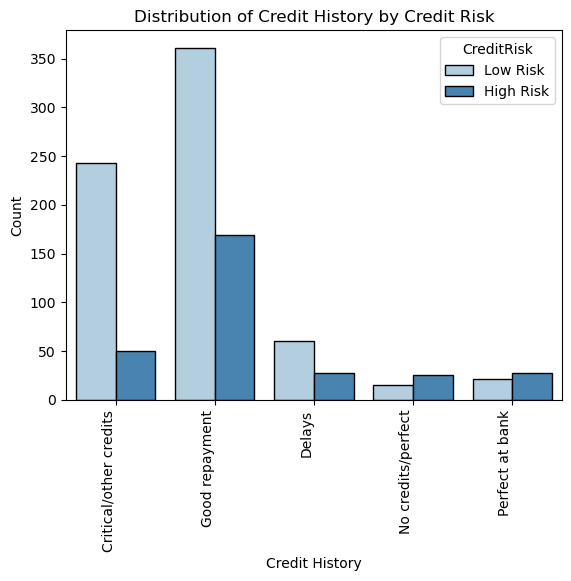

In [131]:
bar_graph(data = df, 
          x = 'CreditHistory', 
          hue = 'CreditRisk', 
          xlabel = 'Credit History', 
          ylabel = 'Count', 
          title = 'Distribution of Credit History by Credit Risk', 
          filename = 'CreditHistory_CreditRisk_barplot.png',
          xtick_rotation = 90)

The largest proportion of High Risk borrowers falls under the "Critical/Other Credits" category. This suggests that borrowers with existing debts outside of their primary lender or a poor credit standing are at a much higher risk of default. Borrowers with "Good Repayment" are mostly Low Risk, but some are still classified as High Risk, meaning repayment history alone is not the sole factor. Individuals with no credit history or perfect repayment records tend to be Low Risk, supporting the idea that clean credit history correlates with better financial standing.

##### 4.2.3.2.3. LoanPurpose and CreditRisk

*LoanPurpose* represents the reason for which the borrower is taking out a loan, such as for purchasing a car, financing education, or covering business expenses. Different loan purposes may have varying levels of risk. Loans for business or large purchases may have a higher risk due to the uncertainty of returns, whereas loans for necessities (e.g., appliances or education) might be lower risk.

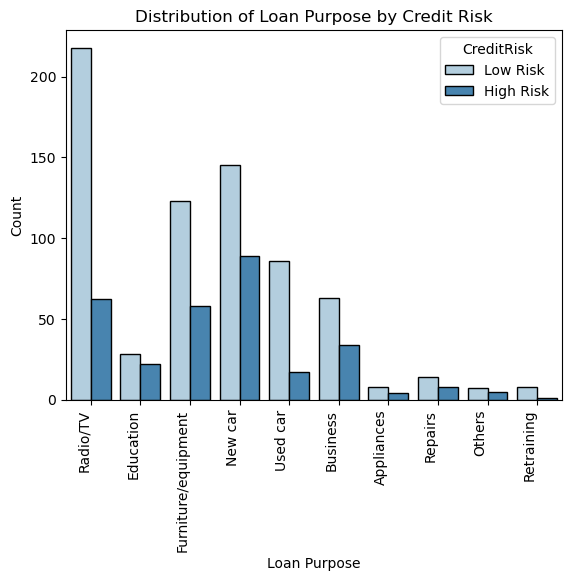

In [132]:
bar_graph(data = df, 
          x = 'LoanPurpose', 
          hue = 'CreditRisk', 
          xlabel = 'Loan Purpose', 
          ylabel = 'Count', 
          title = 'Distribution of Loan Purpose by Credit Risk', 
          filename = 'LoanPurpose_CreditRisk_barplot.png',
          xtick_rotation = 90)

The most common loan purposes in the dataset are Radio/TV purchases and New Cars. A majority of borrowers taking loans for Radio/TV purchases and New Cars are Low Risk. Higher risk borrowers also make up a larger proportion of those who take out loans for a new car. Low risk credit borrowers appear to be more likely to buy a used car over a new car compared to high risk borrowers.

##### 4.2.3.2.4. SavingsAccountBonds and CreditRisk

*SavingsAccountBonds* represents the borrower's savings account balance, categorized into different financial tiers. Borrowers with higher savings are expected to have lower credit risk, as they have more financial stability. Conversely, borrowers with no savings or low balances may be more financially vulnerable and thus higher risk.

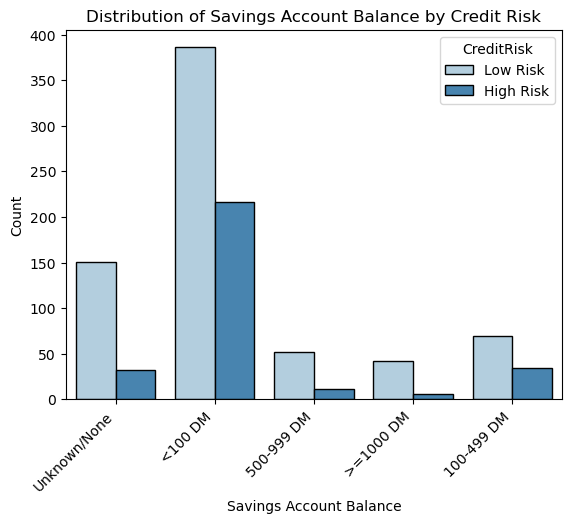

In [133]:
bar_graph(data = df, 
          x = 'SavingsAccountBonds', 
          hue = 'CreditRisk', 
          xlabel = 'Savings Account Balance', 
          ylabel = 'Count', 
          title = 'Distribution of Savings Account Balance by Credit Risk', 
          filename = 'SavingsAccountBonds_CreditRisk_barplot.png')

Most Borrowers Have Less Than 100 DM in Savings. While most of these borrowers are Low Risk, a significant portion are High Risk, suggesting that low savings is associated with a higher likelihood of default. Borrowers with ≥1000 DM in savings are overwhelmingly Low Risk. A significant number of borrowers fall into the "Unknown/None" savings category. The majority are Low Risk, but there are some High Risk borrowers, meaning that not having savings data alone is not enough to predict redit risk.

##### 4.2.3.2.5. EmploymentDuration and CreditRisk

*EmploymentDuration* represents how long a borrower has been employed, categorized into different time ranges (e.g., less than a year, 1-4 years, 4-7 years, and 7+ years). Borrowers with longer employment durations are expected to have greater financial stability and lower credit risk, while those with shorter employment durations or unemployment may be higher risk due to income instability.

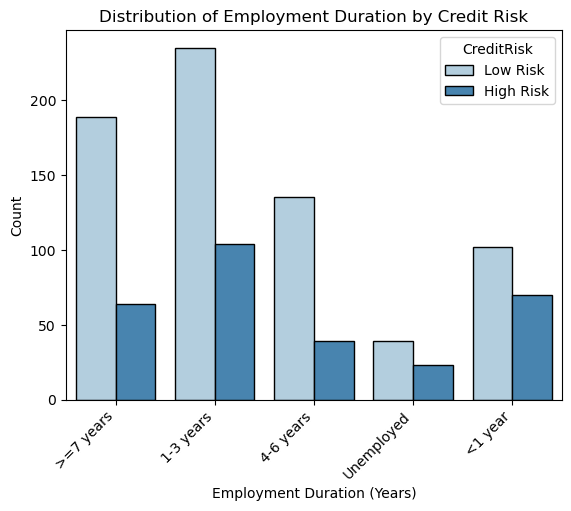

In [134]:
bar_graph(data = df, 
          x = 'EmploymentDuration', 
          hue = 'CreditRisk', 
          xlabel = 'Employment Duration (Years)', 
          ylabel = 'Count', 
          title = 'Distribution of Employment Duration by Credit Risk', 
          filename = 'EmploymentDuration_CreditRisk_barplot.png')


Longer employment durations (≥7 years) are strongly associated with Low Risk borrowers, supporitng the idea that job stability reduces credit risk. Short employment duration (<1 year) and unemployment increase the proportion of High Risk borrowers, supporting the link between financial instability and credit risk. Borrowers with 4-6 years of employment are mostly Low Risk, suggesting that 4+ years of stability significantly improves creditworthiness.

##### 4.2.3.2.6. PersonalStatusSex and CreditRisk

*PersonalStatusSex* represents the borrower's gender and marital status, categorized into different groups such as single, married, divorced, and separated for both males and females. While marital status may affect financial stability, gender itself should not be a direct predictor of credit risk.

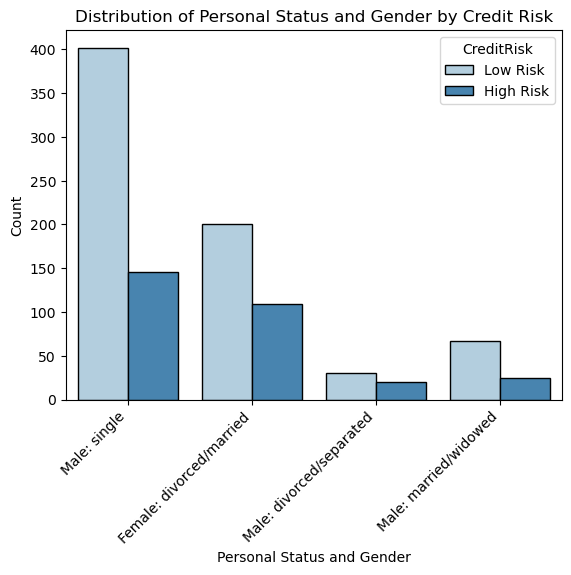

In [135]:
bar_graph(data = df, 
          x = 'PersonalStatusSex', 
          hue = 'CreditRisk', 
          xlabel = 'Personal Status and Gender', 
          ylabel = 'Count', 
          title = 'Distribution of Personal Status and Gender by Credit Risk', 
          filename = 'PersonalStatusSex_CreditRisk_barplot.png')

Single males dominate the dataset but have a high proportion of High Risk borrowers, indicating potential financial instability. Females (divorced/married) are mostly Low Risk, suggesting greater financial stability in these categories. Married/Widowed males have the fewest High Risk cases, supporting the idea that financial stability increases with marriage.

##### 4.2.3.2.7. OtherDebtorsGuarantors and CreditRisk

*OtherDebtorsGuarantors* represents whether the borrower has no co-signers, a co-applicant, or a guarantor on their loan application. Borrowers with no additional debtors may be more financially independent, while those with co-applicants or guarantors may indicate higher financial risk or shared financial obligations.

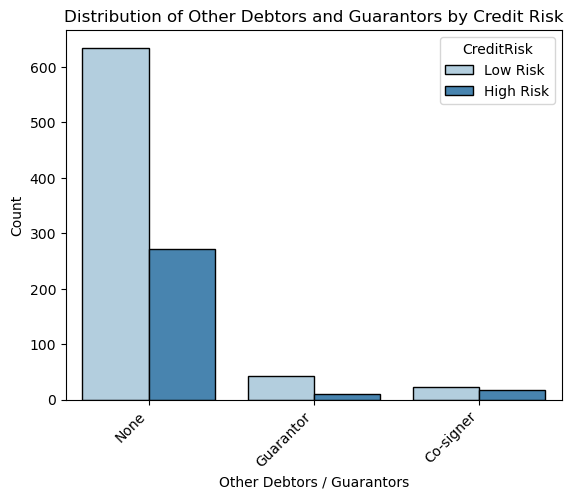

In [136]:
bar_graph(data = df, 
          x = 'OtherDebtorsGuarantors', 
          hue = 'CreditRisk', 
          xlabel = 'Other Debtors / Guarantors', 
          ylabel = 'Count', 
          title = 'Distribution of Other Debtors and Guarantors by Credit Risk', 
          filename = 'OtherDebtorsGuarantors_CreditRisk_barplot.png')

Most borrowers do not have co-signers or guarantors, and these borrowers have a balanced mix of Low and High Risk classifications. Having a guarantor appears to reduce credit risk, as most borrowers in this category are Low Risk. Co-signers are rare, but their risk distribution is more balanced, meaning they are not a strong indicator of credit risk.

##### 4.2.3.2.8. PropertyOwnership and CreditRisk

*PropertyOwnership* indicates whether the borrower owns real estate, savings/life insurance, a car/other valuable assets, or has no property at all. Borrowers with real estate or financial investments may have greater financial stability and thus a lower credit risk, while those with no property may be more financially vulnerable.

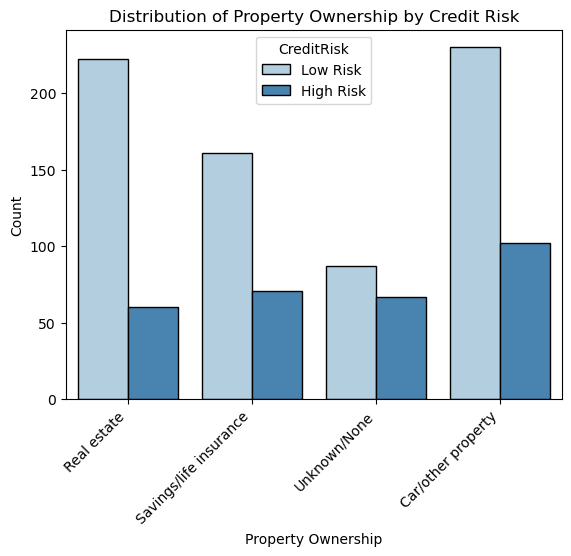

In [137]:
bar_graph(data = df, 
          x = 'PropertyOwnership', 
          hue = 'CreditRisk', 
          xlabel = 'Property Ownership', 
          ylabel = 'Count', 
          title = 'Distribution of Property Ownership by Credit Risk', 
          filename = 'PropertyOwnership_CreditRisk_barplot.png')

Owning real estate or having savings/life insurance appears to be associated with Low Risk borrowers, reinforcing the importance of financial assets in credit risk. Borrowers with no recorded property have a much higher proportion of High Risk classifications, suggesting financial vulnerability.

##### 4.2.3.2.9. OtherInstallmentPlans and CreditRisk 

*OtherInstallmentPlans* indicates whether a borrower has additional installment plans through a bank, stores, or none at all. Borrowers with no other installment plans may have fewer financial obligations and thus lower credit risk, whereas those with multiple installment plans through banks or stores might have higher financial strain.

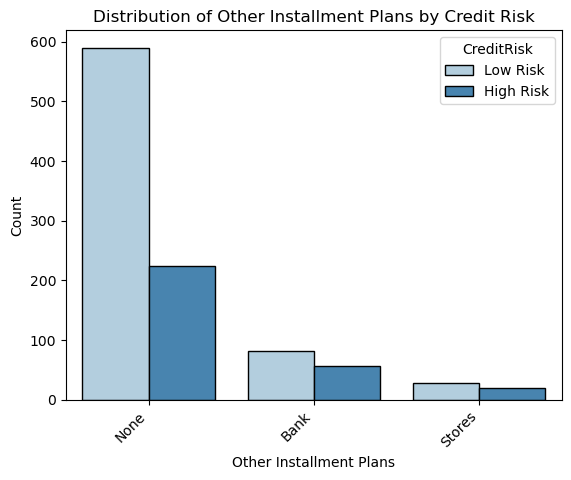

In [138]:
bar_graph(data = df, 
          x = 'OtherInstallmentPlans', 
          hue = 'CreditRisk', 
          xlabel = 'Other Installment Plans', 
          ylabel = 'Count', 
          title = 'Distribution of Other Installment Plans by Credit Risk', 
          filename = 'OtherInstallmentPlans_CreditRisk_barplot.png')

Most Borrowers Have No Other Installment Plans. The majority of borrowers have no other installment plans, and among them, most are classified as Low Risk. However, a substantial number of High Risk borrowers also fall into this category, indicating that while not having additional installments may help, it's not a guarantee of low risk.

##### 4.2.3.2.10. HousingStatus and CreditRisk 

*HousingStatus* indicates whether the borrower rents, owns, or lives in housing for free. Borrowers who own their home may have greater financial stability and lower credit risk, while renters or those living for free may face more financial uncertainty, potentially leading to higher risk.

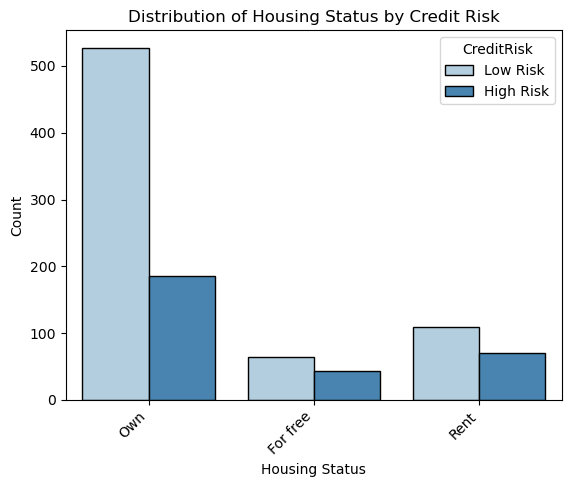

In [139]:
bar_graph(data = df, 
          x = 'HousingStatus', 
          hue = 'CreditRisk', 
          xlabel = 'Housing Status', 
          ylabel = 'Count', 
          title = 'Distribution of Housing Status by Credit Risk', 
          filename = 'HousingStatus_CreditRisk_barplot.png')

 Homeowners are mostly Low Risk, supporting the idea that homeownership is associated with financial stability. Renters have a higher proportion of High Risk borrowers, though many are still Low Risk. Living for free does not show a clear trend, suggesting that financial dependency can go either way in terms of credit risk.

##### 4.2.3.2.11. JobType and CreditRisk

*JobType* categorizes the borrower’s employment into unemployed/unskilled, unskilled resident, skilled employee, and highly qualified/management roles. Borrowers with higher-skilled jobs or management positions are expected to have lower credit risk due to more stable income and career prospects, while unemployed or unskilled workers may face higher financial instability, leading to greater risk.

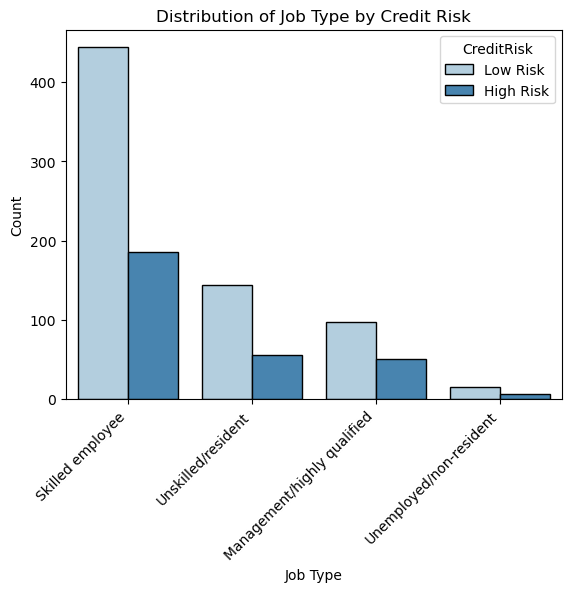

In [140]:
bar_graph(data = df, 
          x = 'JobType', 
          hue = 'CreditRisk', 
          xlabel = 'Job Type', 
          ylabel = 'Count', 
          title = 'Distribution of Job Type by Credit Risk', 
          filename = 'JobType_CreditRisk_barplot.png')

Skilled employees make up the largest borrower group, and most of them are Low Risk. 

##### 4.2.3.2.12. Telephone and CreditRisk 

*Telephone* indicates whether the borrower has a registered telephone number or not. Borrowers with a registered telephone may have more financial stability, as it could be a sign of a stable residence or established credit history. Those without a phone may be less financially secure or more difficult to contact, possibly increasing their credit risk.

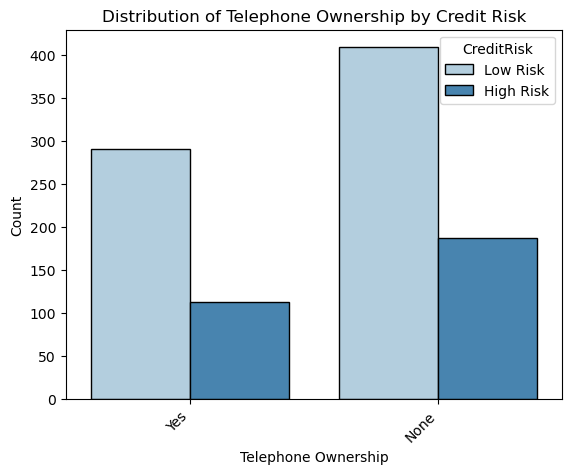

In [141]:
bar_graph(data = df, 
          x = 'Telephone', 
          hue = 'CreditRisk', 
          xlabel = 'Telephone Ownership', 
          ylabel = 'Count', 
          title = 'Distribution of Telephone Ownership by Credit Risk', 
          filename = 'Telephone_CreditRisk_barplot.png')

Borrowers with a registered telephone are more likely to be classified as Low Risk, possibly indicating better financial stability. Not having a telephone does not necessarily indicate High Risk, but there is a higher proportion of High Risk borrowers in this category. While telephone ownership may not be a direct predictor of credit risk, it may serve as an indirect indicator of financial stability and accessibility.

##### 4.2.3.2.13. ForeignWorker and CreditRisk

*ForeignWorker* indicates whether the borrower is a foreign worker (Yes) or not (No). Foreign workers may face more financial instability due to job uncertainty, visa limitations, or limited access to credit, potentially increasing their credit risk. However, if foreign workers are  employed in stable or high skill industries, their credit risk may be comparable to domestic workers.

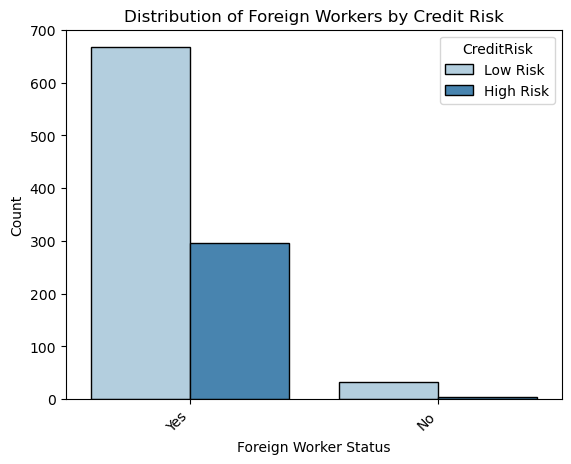

In [142]:
bar_graph(data = df, 
          x = 'ForeignWorker', 
          hue = 'CreditRisk', 
          xlabel = 'Foreign Worker Status', 
          ylabel = 'Count', 
          title = 'Distribution of Foreign Workers by Credit Risk', 
          filename = 'ForeignWorker_CreditRisk_barplot.png')

The dataset is overwhelmingly composed of foreign workers, making them the primary group for credit risk analysis. Foreign workers are mostly Low Risk, though a considerable number are classified as High Risk. Domestic workers are too few in number to draw definitive conclusions about their credit risk.

### 4.2.5. Feature Relationships (Multicollinearity Analysis)

The following section will check for feature relationships among all variables

#### 4.2.5.1. Correlation Heatmap

In [143]:
numeric_corr = df.corr(numeric_only = True)
numeric_corr

,LoanDurationMonths,CreditAmount,InstallmentRate,ResidenceDuration,AgeYears,ExistingCredits,Dependents
LoanDurationMonths,1.000000000,0.624984198,0.074748816,0.034067202,-0.036136374,-0.011283597,-0.023834475
CreditAmount,0.624984198,1.000000000,-0.271315701,0.028926323,0.032716417,0.020794552,0.017142154
InstallmentRate,0.074748816,-0.271315701,1.000000000,0.049302371,0.058265684,0.021668743,-0.071206943
ResidenceDuration,0.034067202,0.028926323,0.049302371,1.000000000,0.266419184,0.089625233,0.042643426
AgeYears,-0.036136374,0.032716417,0.058265684,0.266419184,1.000000000,0.149253582,0.118200833
ExistingCredits,-0.011283597,0.020794552,0.021668743,0.089625233,0.149253582,1.000000000,0.109666700
Dependents,-0.023834475,0.017142154,-0.071206943,0.042643426,0.118200833,0.109666700,1.000000000


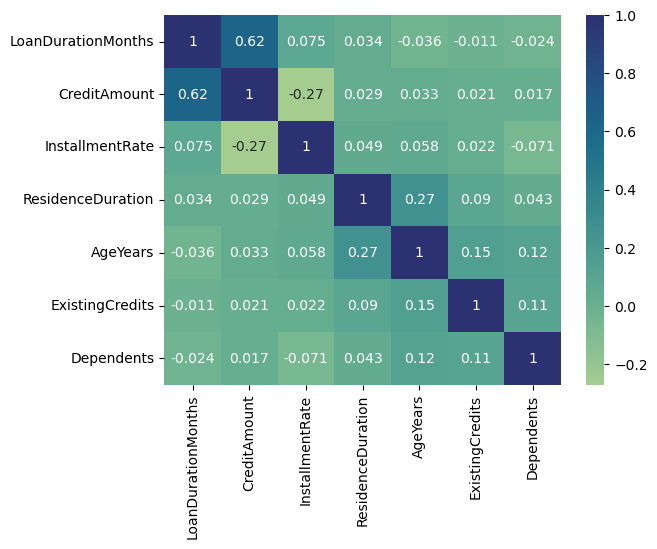

In [144]:
sns.heatmap(data = numeric_corr, annot = True, cmap = 'crest')
full_path = os.path.join(figures_folder, 'numerical_heatmap.png')
plt.savefig(full_path, bbox_inches='tight')

The highest correlation is 0.62 between *CreditAmount* and *LoanDurationMonths*. Larger loans typically require longer repayment periods, so we expect a positive correlation. *ResidenceDuration* and *AgeYears* had the next highest positive correlation at 0.27, Older individuals are more likely to have lived in the same place longer, explaining this moderate correlation. All other variable combinations had a weak or no correlation. 

#### 4.2.5.2. Scatterplot Matrix

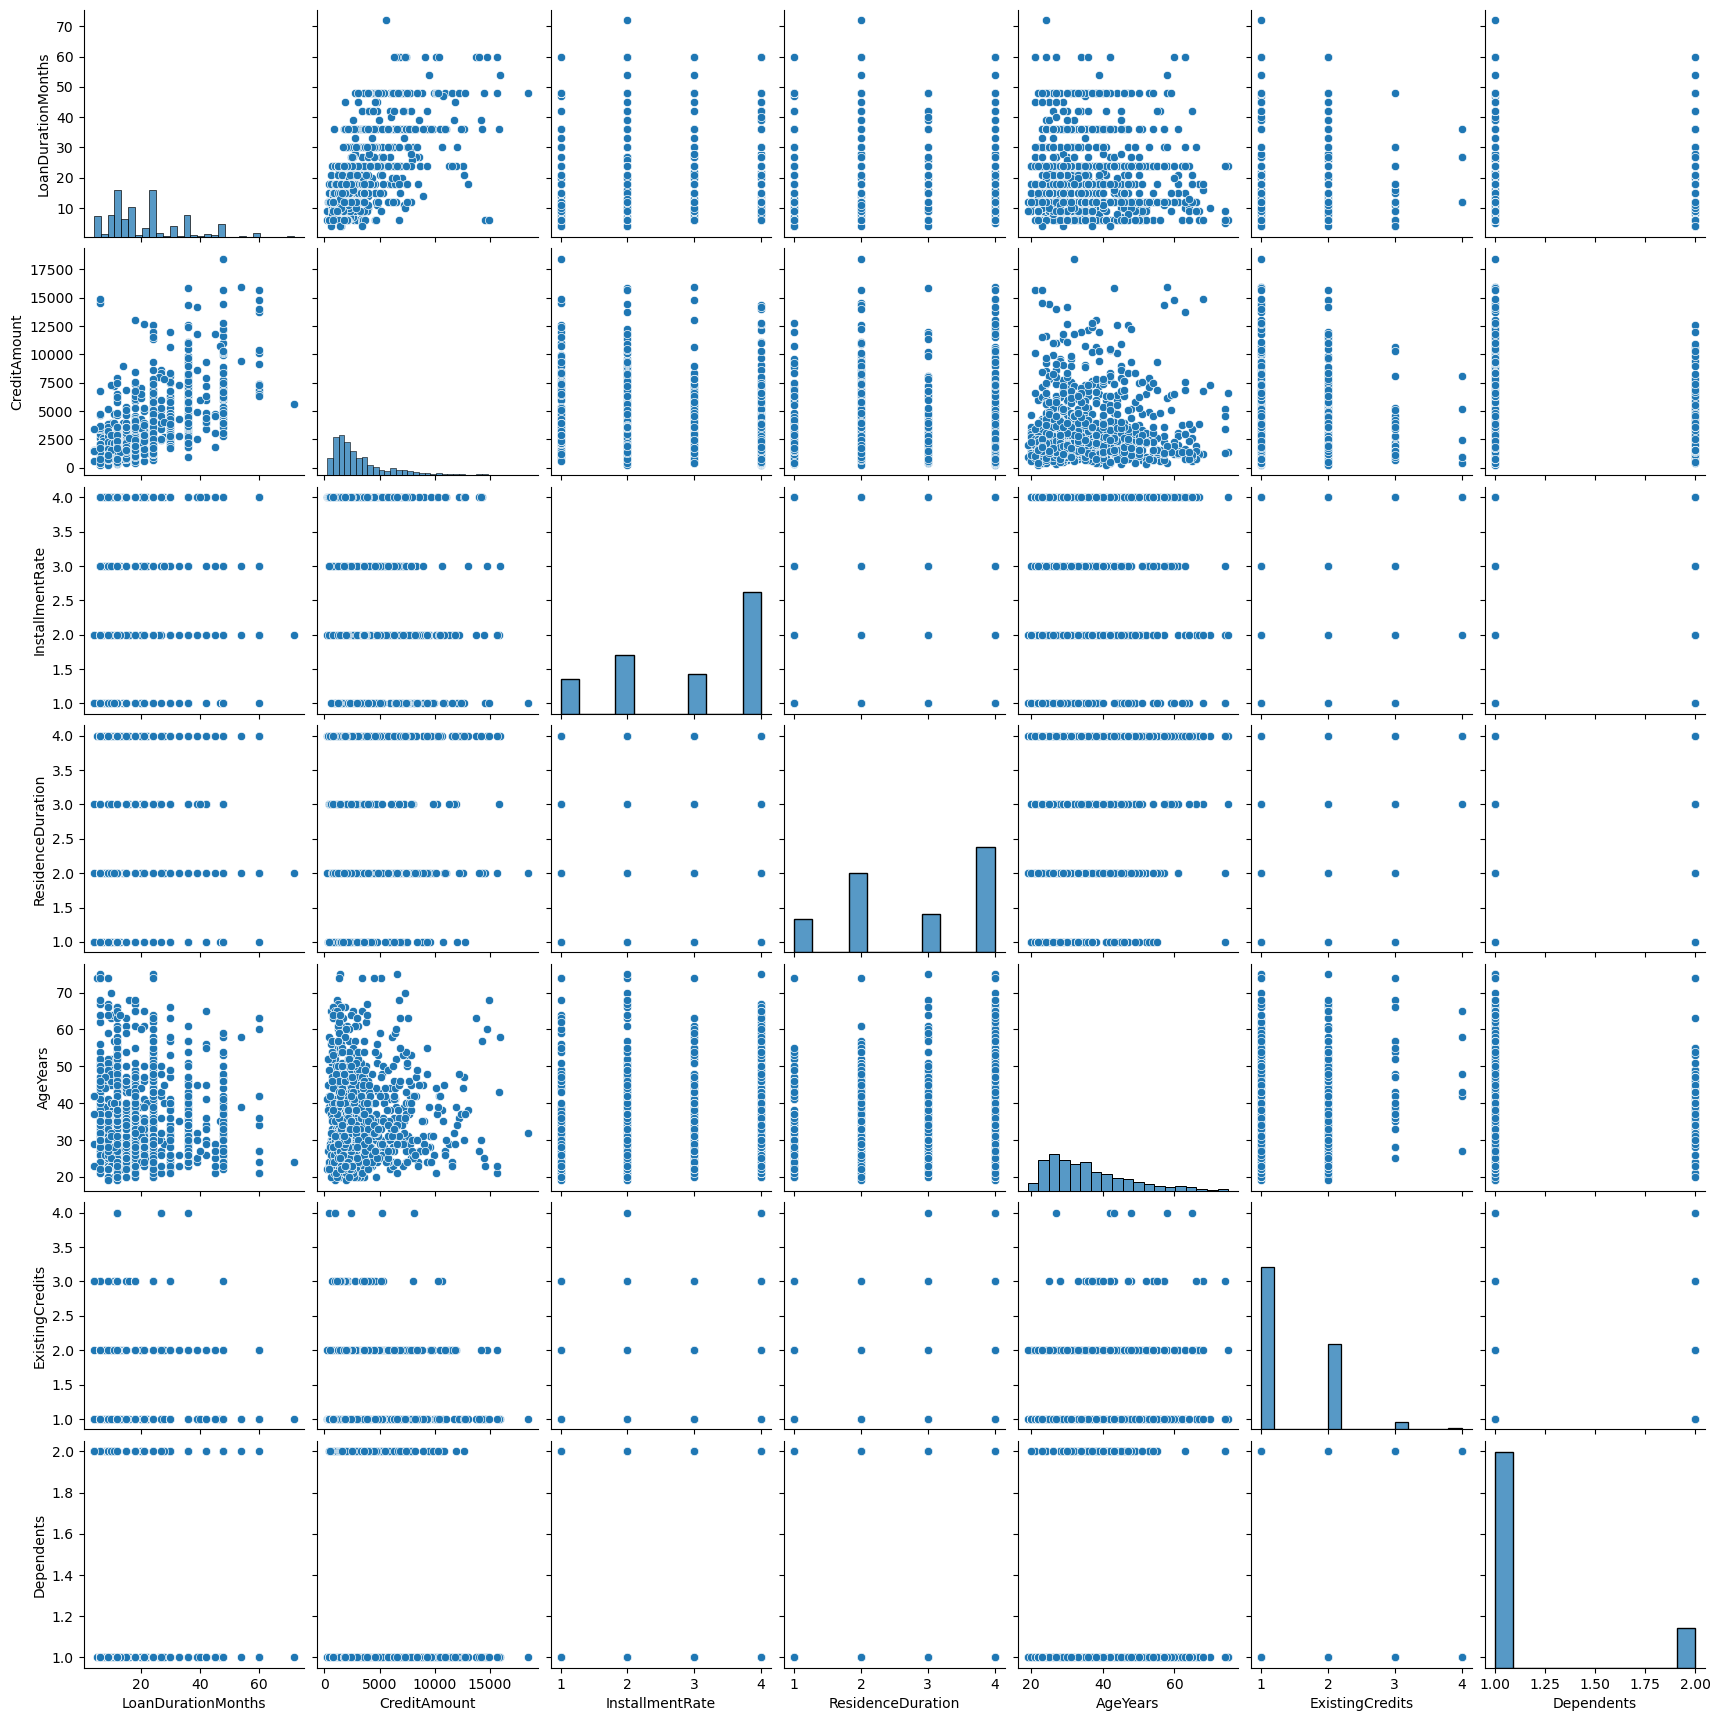

In [145]:
sns.pairplot(df)
full_path = os.path.join(figures_folder, 'numerical_Scatterplot.png')
plt.savefig(full_path, bbox_inches='tight')

#### 4.2.5.2. Variance Inflation Factor (VIF) Analysis

In [146]:
X_num = X.select_dtypes(np.int64)
X_num = sm.add_constant(X_num)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
vif_data

,Feature,VIF
0,const,35.036815460
1,LoanDurationMonths,1.857215357
2,CreditAmount,1.994152461
3,InstallmentRate,1.227526558
4,ResidenceDuration,1.082781146
5,AgeYears,1.121526576
6,ExistingCredits,1.036225769
7,Dependents,1.030098613


All feature VIF values are below 2, which indicates very low multicollinearity.

---

# 5. Data Preprocessing

## 5.1. Split into Training and Test Data

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, shuffle = True, stratify = y, random_state = 42)

### 5.2.2 Categorical Features

#### 5.2.2.1. Chi-Square Testing

In [149]:
import scipy.stats as stats

cat_features = X_train.select_dtypes(object).columns.tolist()

chi2_results = [] 

for feature in cat_features:
    contigency_table = pd.crosstab(index = X_train[feature], columns = y_train)
    chi2, p_value, dof, expected = stats.chi2_contingency(observed = contigency_table)
    chi2_results.append({'Feature': feature, 'Chi-Squared' : chi2, 'P-values' : p_value})

chi2_df = pd.DataFrame(chi2_results).sort_values('P-values')

chi2_df


,Feature,Chi-Squared,P-values
0,CheckingAccountStatus,83.462978518,0.000000000
1,CreditHistory,43.795915436,0.000000007
2,LoanPurpose,38.751359111,0.000012773
3,SavingsAccountBonds,25.151987922,0.000046891
7,PropertyOwnership,18.482997676,0.000349645
9,HousingStatus,11.177776137,0.003739183
8,OtherInstallmentPlans,8.916338465,0.011583551
6,OtherDebtorsGuarantors,8.566063062,0.013800761
4,EmploymentDuration,10.487811900,0.032965293
12,ForeignWorker,2.812705457,0.093520536


*CheckingAccountStatus* has the strongest association with *CreditRisk*. The features that show weak or no significant association are *ForeignWorker*, *PersonalStatusSex*, *Telephone*, and *JobType*.  

#### 5.2.2.2 Mutual Information 

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

cat_features = X_train.select_dtypes(object).columns.tolist()
ohe_cat = ['LoanPurpose', 'PersonalStatusSex', 'OtherDebtorsGuarantors', 'OtherInstallmentPlans']
ordinal_cat = [feature for feature in cat_features if feature not in ohe_cat] # Faster way of determining features for ordinal encoding rather than listing them out


ordinal_categories = [["No checking account", "<0 DM", "0<= ...<200 DM", ">=200 DM"],  # CheckingAccountStatus
                      ["No credits/perfect", "Perfect at bank", "Good repayment", "Delays", "Critical/other credits"],  # CreditHistory
                      ["Unknown/None", "<100 DM", "100-499 DM", "500-999 DM", ">=1000 DM"],  # SavingsAccountBonds
                      ["Unemployed", "<1 year", "1-3 years", "4-6 years", ">=7 years"],  # EmploymentDuration
                      ["Unknown/None", "Car/other property", "Savings/life insurance", "Real estate"],  # PropertyOwnership
                      ["For free", "Rent", "Own"],  # HousingStatus
                      ["Unemployed/non-resident", "Unskilled/resident", "Skilled employee", "Management/highly qualified"],  # JobType
                      ["None", "Yes"],  # Telephone
                      ["No", "Yes"]]  # ForeignWorker

ct = ColumnTransformer([('ordinal', OrdinalEncoder(categories = ordinal_categories), ordinal_cat),
                        ('onehot', OneHotEncoder(handle_unknown = 'ignore'), ohe_cat)]) # Handle_unknown is used just in case a category does not appear in the testing data

X_train_cat_encoded = ct.fit_transform(X_train[cat_features])  # Fit & transform training data
X_test_cat_encoded = ct.transform(X_test[cat_features])  # Transform test data (no fit)

feature_names = ct.get_feature_names_out()

X_train_cat_encoded_df = pd.DataFrame( data = X_train_cat_encoded, columns = feature_names)
X_test_cat_encoded_df = pd.DataFrame(data = X_test_cat_encoded, columns = feature_names)

In [160]:
from sklearn.feature_selection import mutual_info_classif

# Computing the mutual information between categorical features and target feature
MI_scores = mutual_info_classif(X = X_train_cat_encoded_df, y = y_train, discrete_features = True, random_state = 42, n_jobs = -1)

In [161]:
MI_results = pd.DataFrame({'Feature' : feature_names, 'MI Score' : MI_scores})
MI_results.sort_values(by = 'MI Score', ascending = False)

,Feature,MI Score
0,ordinal__CheckingAccountStatus,0.063067845
1,ordinal__CreditHistory,0.031580617
2,ordinal__SavingsAccountBonds,0.019922547
4,ordinal__PropertyOwnership,0.012829096
15,onehot__LoanPurpose_Radio/TV,0.010724936
18,onehot__LoanPurpose_Used car,0.009676279
5,ordinal__HousingStatus,0.007760634
3,ordinal__EmploymentDuration,0.007365701
13,onehot__LoanPurpose_New car,0.006528690
27,onehot__OtherInstallmentPlans_None,0.006036776


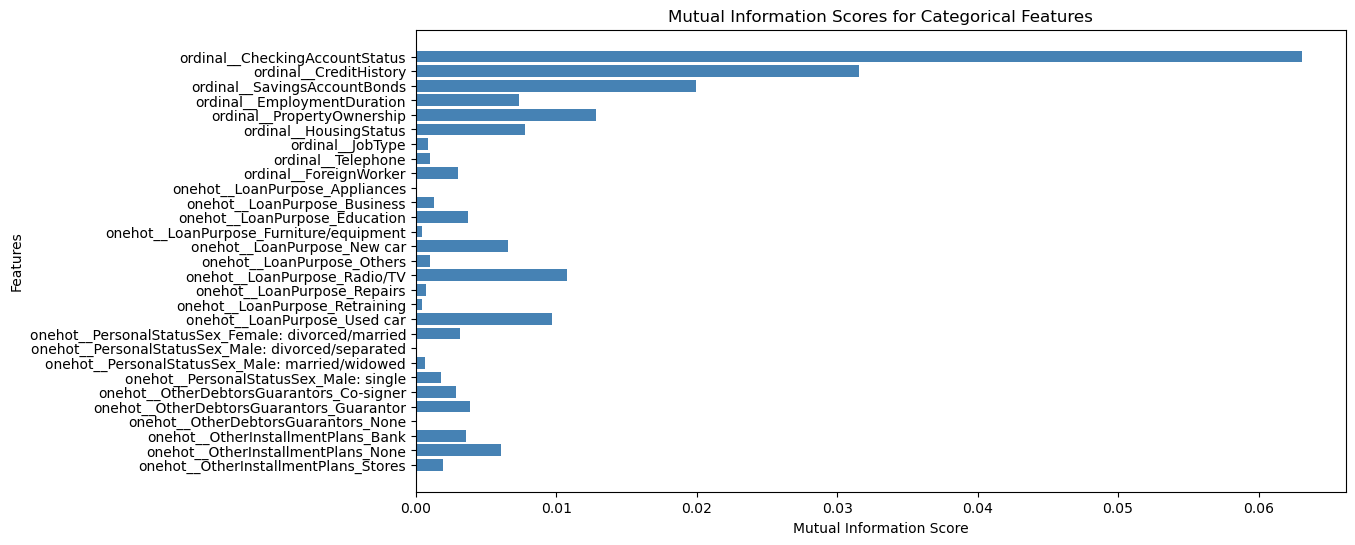

In [162]:
plt.figure(figsize=(12, 6))
plt.barh(MI_results['Feature'], MI_results['MI Score'], color='steelblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information Scores for Categorical Features')
plt.gca().invert_yaxis()  # Highest scores on top
plt.show()

*CheckingAccountStatus* (~0.063) and *CreditHistory* (~0.031) provide the most information about credit risk. *SavingsAccountBonds* (~0.019) and *EmploymentDuration* (~0.007) still contribute some information. Most of the other predictors provide little to no predictive power.

---

# 6. Model Development

## 6.1. Logistic Model

### 6.1.1. Baseline Logistic Regression Model

In [235]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import  OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler

numerical_features = X_train.select_dtypes(include = np.int64).columns.tolist() # All numerical features
log_features = ['LoanDurationMonths', 'CreditAmount', 'AgeYears'] # Features to be log transformed
num_features = [feature for feature in numerical_features if feature not in log_features] # Standard numerical features


cat_features = X_train.select_dtypes(object).columns.tolist() # All categorical features
ohe_cat = ['LoanPurpose', 'PersonalStatusSex', 'OtherDebtorsGuarantors', 'OtherInstallmentPlans', 'Telephone', 'ForeignWorker']
ordinal_cat = [feature for feature in cat_features if feature not in ohe_cat] 

ordinal_categories = [["No checking account", "<0 DM", "0<= ...<200 DM", ">=200 DM"],  # CheckingAccountStatus
                      ["No credits/perfect", "Perfect at bank", "Good repayment", "Delays", "Critical/other credits"],  # CreditHistory
                      ["Unknown/None", "<100 DM", "100-499 DM", "500-999 DM", ">=1000 DM"],  # SavingsAccountBonds
                      ["Unemployed", "<1 year", "1-3 years", "4-6 years", ">=7 years"],  # EmploymentDuration
                      ["Unknown/None", "Car/other property", "Savings/life insurance", "Real estate"],  # PropertyOwnership
                      ["For free", "Rent", "Own"],  # HousingStatus
                      ["Unemployed/non-resident", "Unskilled/resident", "Skilled employee", "Management/highly qualified"]]  # JobType] 

log_scaler = FunctionTransformer(func = np.log, inverse_func = np.exp)
standard_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder(categories = ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)
ohe_encoder = OneHotEncoder(handle_unknown='ignore')

ct = ColumnTransformer(transformers=[('log_standardize', Pipeline(steps=[('log', log_scaler), ('scale', standard_scaler)]), log_features), 
                                     ('ordinal_encode', ordinal_encoder, ordinal_cat),
                                     ('onehot_encode', ohe_encoder, ohe_cat)])

log_pipeline = Pipeline(steps = [('preprocessing', ct),
                                 ('Log_clf', LogisticRegression(max_iter = 1000, class_weight = 'balanced'))])

In [236]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X = X_train, y = y_train)
dummy_pred = dummy_clf.predict(X = X_train)
dummy_pred[:10]

array(['Low Risk', 'Low Risk', 'Low Risk', 'Low Risk', 'Low Risk',
       'Low Risk', 'Low Risk', 'Low Risk', 'Low Risk', 'Low Risk'],
      dtype='<U8')

In [237]:
log_pipeline.fit(X = X_train, y = y_train)
log_pred = log_pipeline.predict(X_train)

#### Performance Metrics

In [238]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_score(y_true = y_train, y_pred = dummy_pred)


0.7

The dummy classifier has an accuracy of 70%

In [239]:
accuracy_score(y_true = y_train, y_pred = log_pred)

0.7285714285714285

In [240]:
precision_score(y_true = y_train, y_pred = log_pred, pos_label = 'High Risk')

0.5344827586206896

In [242]:
recall_score(y_true = y_train, y_pred = log_pred, pos_label = 'High Risk')

0.7380952380952381

In [243]:
f1_score(y_true = y_train, y_pred = log_pred, pos_label = 'High Risk')

0.62

In [244]:
cm_log = confusion_matrix(y_true = y_train, y_pred = log_pred, labels = ['Low Risk', 'High Risk'])
cm_log

array([[355, 135],
       [ 55, 155]])

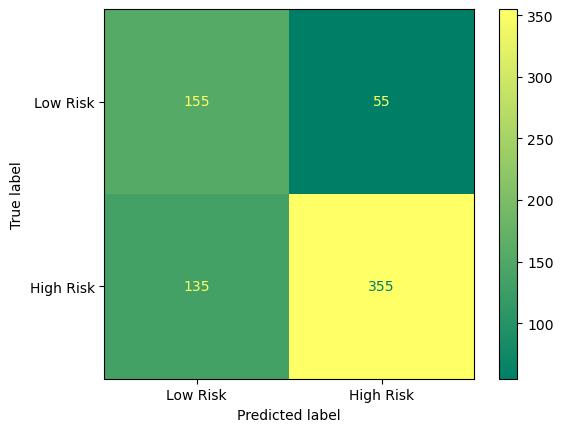

In [246]:
log_reg_cm = confusion_matrix(y_true = y_train, y_pred = log_pred)
log_cm_disp = ConfusionMatrixDisplay(confusion_matrix = log_reg_cm, display_labels = ['Low Risk', 'High Risk'])
log_cm_disp.plot(cmap = 'summer');
plt.show();

The baseline logistic regression model achieved an accuracy of 72.9%, indicating that approximately 73% of predictions were correct. However, since the primary concern is minimizing misclassification of high-risk individuals, precision and recall must be examined more closely. The precision score of 53.4% suggests that when the model predicts a borrower as "High Risk," it is correct about 53% of the time. The recall score of 73.8% indicates that the model successfully identifies 73.8% of actual high-risk borrowers, but still misses around 26% of them. The F1-score of 0.62 provides a balance between precision and recall, showing room for improvement.

The confusion matrix reveals that the model correctly classified 355 Low-Risk borrowers and 155 High-Risk borrowers, but misclassified 135 Low-Risk individuals as High-Risk and 55 High-Risk individuals as Low-Risk. Since false negatives (55 cases) are more critical in this context—where a high-risk borrower is incorrectly classified as low-risk—further improvements are necessary to increase recall while maintaining reasonable precision. Adjusting the decision threshold or incorporating class-weighting or resampling techniques could help mitigate this issue.

In [247]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator = log_pipeline, X = X_train, y = y_train, scoring = 'accuracy', cv = 5)

array([0.69285714, 0.66428571, 0.68571429, 0.70714286, 0.72142857])

The baseline logistic regression model does not appear to be overfitting the data according to the results of the k-fold cross validation.

#### Hyperparameter Tuning

In [263]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # L1 Penalty (Lasso)
    {'Log_clf__penalty': ['l1'],
     'Log_clf__C': [1, 10, 100],
     'Log_clf__class_weight': ['balanced', {'Low Risk': 1, 'High Risk': 2}, {'Low Risk': 1, 'High Risk': 3 }]},
    # L2 Penalty (Ridge)
    {'Log_clf__penalty': ['l2'],
     'Log_clf__C': [1, 10, 100],
     'Log_clf__class_weight': ['balanced', {'Low Risk': 1, 'High Risk': 2}, {'Low Risk': 1, 'High Risk': 3 }]},
    # ElasticNet Penalty (L1 + L2)
    {'Log_clf__penalty': ['elasticnet'],
     'Log_clf__C': [1, 10, 100],
     'Log_clf__l1_ratio': [0.1, 0.5, 0.9],  # Only applicable for elasticnet
     'Log_clf__class_weight': ['balanced', {'Low Risk': 1, 'High Risk': 2}, {'Low Risk': 1, 'High Risk': 3 }]}]

logistic_pipeline = Pipeline(steps = [('preprocessing', ct),
                                      ('Log_clf', LogisticRegression(solver='saga', max_iter=5000))])

grid_log = GridSearchCV(estimator = logistic_pipeline, param_grid = param_grid, cv = 3, n_jobs = -1, scoring = 'accuracy')

In [264]:
grid_log.fit(X = X_train, y = y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('log_standardize',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log'>,
                                                                                                              inverse_func=<ufunc 'exp'>)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['LoanDurationMonths',
                                                                          'CreditAmount',
                                                                          'AgeYears']),
                                                                        ('ordinal_encode',
                                                                         OrdinalEncoder(categories=[['No '
                                                                                                     'checking '
                                                                                                     'account',...
                          'Log_clf__penalty': ['l1']},
                         {'Log_clf__C': [1, 10, 100],
                          'Log_clf__class_weight': ['balanced',
                                                    {'High Risk': 2,
                                                     'Low Risk': 1},
                                                    {'High Risk': 3,
                                                     'Low Risk': 1}],
                          'Log_clf__penalty': ['l2']},
                         {'Log_clf__C': [1, 10, 100],
                          'Log_clf__class_weight': ['balanced',
                                                    {'High Risk': 2,
                                                     'Low Risk': 1},
                                                    {'High Risk': 3,
                                                     'Low Risk': 1}],
                          'Log_clf__l1_ratio': [0.1, 0.5, 0.9],
                          'Log_clf__penalty': ['elasticnet']}],
             scoring='accuracy')

In [265]:
grid_log.best_params_

{'Log_clf__C': 1,
 'Log_clf__class_weight': {'Low Risk': 1, 'High Risk': 2},
 'Log_clf__penalty': 'l1'}

In [266]:
grid_log_pred = grid_log.predict(X = X_train)

In [ ]:
accuracy_score(y_true = y_train, y_pred = grid_log_pred) # 0.7285714285714285

0.7371428571428571

A 0.4% improvement from hyperparameter tuning is a strong indicator that the model is already performing close to its capacity and that further parameter tweaks will not significantly enhance performance. This is an indicator that the logistic regression model may not fit the data

## 6.2. Tree-Based Models 

In [157]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_scores = cross_val_score(estimator = tree_clf, X = X_train_cat_encoded_df, y = y_train, cv = 3)
tree_scores

array([0.7008547 , 0.65236052, 0.69098712])

## 6.3. Support Vector Machine

In [158]:
from sklearn.svm import SVC

svc_clf = SVC()
svc_scores = cross_val_score(estimator = svc_clf, X = X_train_scaled_encoded_df, y = y_train, cv = 3)
svc_scores

array([0.74786325, 0.75107296, 0.75536481])

---

# 7. Model Evaluation

---

# 8. Results

---

## 9. Conclusions

---